# Protein Sequence Classification: Machine Learning

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm
import random

import tensorflow as tf
# tf.config.run_functions_eagerly(True)
import torch


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To ensure reproducibility
# for keras operations that use random numbers internally
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Loading cleaned protein sequence data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('train_new_ecod.csv')
test_data = pd. read_csv('test_new_ecod.csv')

## Machine learning Models

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

In [ ]:
X_training, y_training = train_data['clean_sequence'], train_data['classification']
X_testing, y_testing = test_data['clean_sequence'], test_data['classification']

In [ ]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_training = le.fit_transform(y_training)
y_testing = le.transform(y_testing)

In [ ]:
import joblib
labelencoder = {'le': le}
joblib.dump(labelencoder, "label_encoder.joblib")

['label_encoder.joblib']

In [ ]:
le.inverse_transform(y_training)

array(['oxygen transport', 'hydrolase', 'transferase inhibitor', ...,
       'immunoglobulin', 'immunoglobulin', 'electron transport'],
      dtype=object)

In [ ]:
# creating list of all 75 classes
labels = le.classes_
print(labels)

['allergen' 'antibiotic hydrolase' 'antibiotic transferase'
 'antimicrobial protein' 'apoptosis' 'biosynthetic protein'
 'biotin-binding protein' 'blood clotting' 'calcium-binding protein'
 'cell adhesion' 'cell cycle' 'cell invasion' 'chaperone'
 'contractile protein' 'cytokine' 'de novo protein' 'dna binding protein'
 'electron transport' 'endocytosis' 'endocytosis/exocytosis'
 'flavoprotein' 'fluorescent protein' 'gene regulation'
 'growth factor hormone' 'hormone' 'hormone receptor' 'hydrolase'
 'hydrolase inhibitor' 'immune system' 'immunoglobulin' 'isomerase'
 'isomerase inhibitor' 'lectin' 'ligase' 'ligase inhibitor'
 'lipid binding protein' 'lipid transport' 'luminescent protein' 'lyase'
 'lyase inhibitor' 'membrane protein' 'metal binding protein'
 'metal transport' 'motor protein' 'nuclear protein' 'oxidoreductase'
 'oxidoreductase inhibitor' 'oxygen storage' 'oxygen transport'
 'peptide binding protein' 'phosphotransferase' 'photosynthesis'
 'plant protein' 'protein binding'

#### USING UNI-GRAMS

In [ ]:
# Create a Count Vectorizer to gather the unique elements in sequence
vect_1 = CountVectorizer(analyzer = 'char', ngram_range = (1,1))      # using uni-grams

# Fit and Transform CountVectorizer
vect_1.fit(X_training)
X_train_1 = vect_1.transform(X_training)
X_test_1 = vect_1.transform(X_testing)


##### KNeighborsClassifier

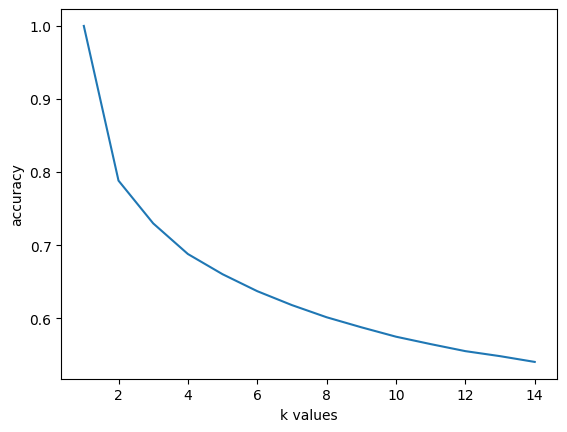

In [ ]:
# Finding k values in range(1,15)
score_list = []
for each in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = each)
    knn.fit(X_train_1, y_training)
    score_list.append(knn.score(X_train_1, y_training))

plt.plot(range(1,15),score_list)
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# Define the scoring metrics
scoring = {'accuracy': 'accuracy', 'f1_weighted': make_scorer(f1_score, average='weighted'), 'f1_macro': make_scorer(f1_score, average='macro')}

In [ ]:
# KNeighborsClassifier
# It took approximately 3-4 hours to train the model
params_knn = {'n_neighbors': list(range(2,10)),
         'weights': ['uniform', 'distance'],
         'leaf_size': list(range(10,20))
        }
knn1 = KNeighborsClassifier()
gs_knn1 = RandomizedSearchCV(knn1, param_distributions=params_knn, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
gs_knn1.fit(X_train_1, y_training)
#See the best results:
# Best parameter set
print('Best parameters found:\n', gs_knn1.best_params_)
print('Best score found:\n', gs_knn1.best_score_)

Best parameters found:
 {'weights': 'distance', 'n_neighbors': 5, 'leaf_size': 13}
Best score found:
 0.5900312753161896


In [ ]:
# Extract the results
results = gs_knn1.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
print(f"F1 Score (weighted): {f1_mean:.4f} ± {f1_std:.4f}")
print(f"F1 Score (macro): {f1_macro_mean:.4f} ± {f1_macro_std:.4f}")


Accuracy: 0.5900 ± 0.1153
F1 Score (weighted): 0.5822 ± 0.1125
F1 Score (macro): 0.4548 ± 0.1018


In [ ]:
best_knn1 = gs_knn1.best_estimator_
best_knn1

KNeighborsClassifier(leaf_size=13, weights='distance')

In [ ]:
knn_pred1 = best_knn1.predict(X_test_1)
acc_knn1 = accuracy_score(knn_pred1, y_testing)
print(f'accuracy: {acc_knn1:.2f}')
f1_knn1 = f1_score(y_testing, knn_pred1, average='weighted')
print(f'f1 score: {f1_knn1:.2f}')

f1_macro_knn1 = f1_score(y_testing, knn_pred1, average='macro')
print(f'Macro f1 score: {f1_macro_knn1:.2f}')

accuracy: 0.54
f1 score: 0.50
Macro f1 score: 0.43



In [ ]:
accuracy_list1 = []
f1_list1 = []
macro_f1_list1 = []
# accuracy_list1.append(acc_knn1)
# f1_list1.append(f1_knn1)
# macro_f1_list1.append(f1_macro_knn1)



accuracy_list1.append(0.54)
f1_list1.append(0.50)
macro_f1_list1.append(0.43)


##### MultinomialNB

In [ ]:
# Naive Bayes Model
# It took approximately 2-3 hours to train the model
params_nb = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0],
        }

nb1 = MultinomialNB(fit_prior=True)
gs_nb1 = RandomizedSearchCV(nb1, param_distributions=params_nb, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
gs_nb1.fit(X_train_1, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_nb1.best_params_)
print('Best score found:\n', gs_nb1.best_score_)

Best parameters found:
 {'alpha': 0.5}
Best score found:
 0.15565768400407934


In [ ]:
best_nb1 = gs_nb1.best_estimator_
best_nb1

MultinomialNB(alpha=0.5)

In [ ]:
NB_pred1 = best_nb1.predict(X_test_1)
acc_nb1 = accuracy_score(NB_pred1, y_testing)
print('accuracy: %s' % acc_nb1)
f1_nb1 = f1_score(y_testing, NB_pred1, average='weighted')
print('f1 score: %s' % f1_nb1)
macro_f1_nb1 = f1_score(y_testing, NB_pred1, average='macro')

# accuracy_list1.append(acc_nb1)
# f1_list1.append(f1_nb1)
# macro_f1_list1.append(macro_f1_nb1)

accuracy: 0.18
f1 score: 0.17
Macro f1 score: 0.10



In [ ]:
accuracy_list1.append(0.18)
f1_list1.append(0.17)
macro_f1_list1.append(0.10)

##### Logistic Regression

In [ ]:
# Logistic Regression Classifier
# It took approximately 1 hours to train the model
params_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 1.0, 5.0],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
}

logreg1 = LogisticRegression(max_iter=300, class_weight = 'balanced', random_state=random_seed, verbose = 0)
gs_lr1 = RandomizedSearchCV(logreg1, param_distributions=params_lr, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_lr1.fit(X_train_1, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_lr1.best_params_)
print('Best score found:\n', gs_lr1.best_score_)

Best parameters found:
 {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}
Best score found:
 0.09006626324926921


In [ ]:
best_lr1 = gs_lr1.best_estimator_
best_lr1

LogisticRegression(class_weight='balanced', max_iter=300, random_state=42,
                   solver='newton-cg')

In [ ]:
best_lr1 = gs_lr1.best_estimator_
lr_pred1 = best_lr1.predict(X_test_1)
acc_lr1 = accuracy_score(lr_pred1, y_testing)
print(f'accuracy: {acc_lr1:.2f}')
f1_lr1 = f1_score(y_testing, lr_pred1, average='weighted')
print(f'f1 score: {f1_lr1:.2f}')
macro_f1_lr1 = f1_score(y_testing, lr_pred1, average='macro')
print(f'Macro f1 score: {macro_f1_lr1:.2f}')

accuracy: 0.11
f1 score: 0.11
Macro f1 score: 0.09



In [ ]:
accuracy_list1.append(0.11)
f1_list1.append(0.11)
macro_f1_list1.append(0.09)

##### MLP Classifier

In [ ]:
# MLPClassifier
# It took approximately 4-5 hours to train the model
params_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100,100,100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['invscaling','constant','adaptive'],
}

mlp1 = MLPClassifier(max_iter=300, activation='relu', solver='adam', random_state=random_seed)
gs_mlp1 = RandomizedSearchCV(mlp1, param_distributions=params_mlp, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_mlp1.fit(X_train_1, y_training)

/Users/humaperveen/anaconda3/envs/tensorflow_apple/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/humaperveen/anaconda3/envs/tensorflow_apple/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=MLPClassifier(max_iter=300, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': [0.01],
                                        'hidden_layer_sizes': [(100, 100, 100)],
                                        'learning_rate': ['invscaling']},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring={'accuracy': 'accuracy',
                            'f1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                            'f1_weighted': make_scorer(f1_score, response_method='predict', average=weighted)})

In [ ]:
# Best paramete set
print('Best parameters found:\n', gs_mlp1.best_params_)
print('Best score found:\n', gs_mlp1.best_score_)

Best parameters found:
 {'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.01}
Best score found:
 0.4555781642286223


In [ ]:
best_mlp1 = gs_mlp1.best_estimator_
best_mlp1

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 100, 100),
              learning_rate='invscaling', max_iter=300, random_state=42)

In [ ]:
mlp_pred1 = best_mlp1.predict(X_test_1)
acc_mlp1 = accuracy_score(mlp_pred1, y_testing)
print(f'accuracy: {acc_mlp1:.2f}')
f1_mlp1 = f1_score(y_testing, mlp_pred1, average='weighted')
print(f'f1 score: {f1_mlp1:.2f}')
macro_f1_mlp1 = f1_score(y_testing, mlp_pred1, average='macro')
print(f'Macro f1 score: {macro_f1_mlp1:.2f}')

accuracy: 0.41
f1 score: 0.39
Macro f1 score: 0.30



In [ ]:
accuracy_list1.append(0.41)
f1_list1.append(0.39)
macro_f1_list1.append(0.30)

##### Decision Tree Classifier

In [ ]:
#Decision Tree Classifier
# It took approximately 2-3 hours to train the model
params_dtc = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
}

dtc1 = DecisionTreeClassifier(min_samples_split=2, class_weight = 'balanced', random_state=random_seed)
gs_dtc1 = RandomizedSearchCV(dtc1, param_distributions=params_dtc, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_dtc1.fit(X_train_1, y_training)
# Best paramete set
print('Best parameters found:\n', gs_dtc1.best_params_)
print('Best score found:\n', gs_dtc1.best_score_)

Best parameters found:
 {'splitter': 'best', 'criterion': 'entropy'}
Best score found:
 0.5004897877446361


In [ ]:
best_dtc1 = gs_dtc1.best_estimator_
best_dtc1

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=42)

In [ ]:
dtc_pred1 = best_dtc1.predict(X_test_1)
acc_dtc1 = accuracy_score(dtc_pred1, y_testing)
print(f'accuracy: {acc_dtc1:.2f}')
f1_dtc1 = f1_score(y_testing, dtc_pred1, average='weighted')
print(f'f1 score: {f1_dtc1:.2f}')
macro_f1_dtc1 = f1_score(y_testing, dtc_pred1, average='macro')
print(f'Macro f1 score: {macro_f1_dtc1:.2f}')

accuracy: 0.45
f1 score: 0.43
Macro f1 score: 0.30



In [ ]:
accuracy_list1.append(0.45)
f1_list1.append(0.43)
macro_f1_list1.append(0.30)

##### Random Forest Classifier

In [ ]:
#Random Forest Classifier
# It took approximately 2-3 hours to train the model
params_rfc = {
    'n_estimators': [10,20,30,40,50,100],
    'criterion': ['gini', 'entropy'],

}

rfc1 = RandomForestClassifier(min_samples_split = 2, class_weight = 'balanced', verbose = 0, random_state=random_seed)
gs_rfc1 = RandomizedSearchCV(rfc1, param_distributions=params_rfc, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_rfc1.fit(X_train_1, y_training)
# Best paramete set
print('Best parameters found:\n', gs_rfc1.best_params_)
print('Best score found:\n', gs_rfc1.best_score_)

Best parameters found:
 {'n_estimators': 100, 'criterion': 'entropy'}
Best score found:
 0.5916903265943536


In [ ]:
best_rfc1 = gs_rfc1.best_estimator_
best_rfc1

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       random_state=42)

In [ ]:
rfc_pred1 = best_rfc1.predict(X_test_1)
acc_rfc1 = accuracy_score(rfc_pred1, y_testing)
print(f'accuracy: {acc_rfc1:.2f}')
f1_rfc1 = f1_score(y_testing, rfc_pred1, average='weighted')
print(f'f1 score: {f1_rfc1:.2f}')
macro_f1_rfc1 = f1_score(y_testing, rfc_pred1, average='macro')
print(f'Macro f1 score: {macro_f1_rfc1:.2f}')

accuracy: 0.55
f1 score: 0.52
Macro f1 score: 0.44



In [ ]:
accuracy_list1.append(0.55)
f1_list1.append(0.52)
macro_f1_list1.append(0.44)

##### XGBoost Classifier

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
#XGBoost Classifier
# It took approximately 3-4 hours to train the model
params_xgb = {
    'n_estimators': [100,200,300,400,500],
    'max_depth': [3, 5, 7],
    'learning_rate':[0.0001, 0.001, 0.01, 0.1]
}

xgb1 = XGBClassifier(gamma = 0.1, tree_method = 'hist', random_state=random_seed)
gs_xgb1 = RandomizedSearchCV(xgb1, param_distributions=params_xgb, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_xgb1.fit(X_train_1, y_training)
# Best paramete set
print('Best parameters found:\n', gs_xgb1.best_params_)
print('Best score found:\n', gs_xgb1.best_score_)

Best parameters found:
 {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1}
Best score found:
 0.5827472177970386


In [ ]:
best_xgb1 = gs_xgb1.best_estimator_
best_xgb1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
xgb_pred1 = best_xgb1.predict(X_test_1)
acc_xgb1 = accuracy_score(xgb_pred1, y_testing)
print(f'accuracy: {acc_xgb1:.2f}')
f1_xgb1 = f1_score(y_testing, xgb_pred1, average='weighted')
print(f'f1 score: {f1_xgb1:.2f}')
macro_f1_xgb1 = f1_score(y_testing, xgb_pred1, average='macro')
print(f'Macro f1 score: {macro_f1_xgb1:.2f}')

accuracy: 0.54
f1 score: 0.51
Macro f1 score: 0.44



In [ ]:
accuracy_list1.append(0.54)
f1_list1.append(0.51)

macro_f1_list1.append(0.44)

##### Voting Classifier

In [ ]:
# group / ensemble of models
estimator1 = []
estimator1.append(('RFC', RandomForestClassifier(n_estimators = 100, min_samples_split = 2, criterion = 'entropy', verbose = 0, class_weight = 'balanced', random_state=random_seed, n_jobs = -1)))
estimator1.append(('KNN', KNeighborsClassifier(n_neighbors=5, leaf_size = 13, weights = 'distance', n_jobs = -1)))
estimator1.append(('XGB', XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1)))

In [ ]:
# Voting Classifier with soft voting
# It took approximately 3-4 hours to train the model
vot_soft1 = VotingClassifier(estimators = estimator1, voting ='soft', n_jobs = -1)
vot_soft1.fit(X_train_1, y_training)
vots_pred1 = vot_soft1.predict(X_test_1)

# using accuracy_score metric to predict accuracy and f1_score to predict f1 score
acc_vots1 = accuracy_score(y_testing, vots_pred1)
print(f'accuracy: {acc_vots1:.2f}')
f1_vots1 = f1_score(y_testing, vots_pred1, average='weighted')
print(f'f1 score: {f1_vots1:.2f}')
macro_f1_vots1 = f1_score(y_testing, vots_pred1, average='macro')
print(f'Macro f1 score: {macro_f1_vots1:.2f}')

accuracy: 0.57
f1 score: 0.53
Macro f1 score: 0.46



In [ ]:
accuracy_list1.append(0.57)
f1_list1.append(0.53)

macro_f1_list1.append(0.46)

##### Stacking Classifier

In [ ]:
# It took approximately 3-4 hours to train the model
meta_model1 = StackingClassifier(
    estimators=[
        ('KNN', KNeighborsClassifier(n_neighbors=5, leaf_size = 13, weights = 'distance', n_jobs = -1)),
        ('RFC', RandomForestClassifier(n_estimators = 100, min_samples_split = 2, criterion = 'entropy', verbose = 0, class_weight = 'balanced', random_state=random_seed, n_jobs = -1)),
        ('XGB', XGBClassifier(booster = 'gbtree', n_estimators = 400, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1))
    ],
    final_estimator=XGBClassifier(booster = 'gbtree', n_estimators = 400, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1), # LogisticRegression(solver = 'newton-cg', penalty = 'l2', class_weight = 'balanced', C = 1.0, random_state=random_seed, verbose = 1, n_jobs = -1)
    stack_method = 'auto',
    cv = 3,
    n_jobs = -1
)
meta_model1.fit(X_train_1, y_training)

StackingClassifier(cv=3,
                   estimators=[('KNN',
                                KNeighborsClassifier(leaf_size=13, n_jobs=-1,
                                                     weights='distance')),
                               ('RFC',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              devi...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=400, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...),
                   n_jobs=-1)

In [ ]:
meta_pred1 = meta_model1.predict(X_test_1)
# using accuracy_score
acc_meta1 = accuracy_score(y_testing, meta_pred1)
print(f'accuracy: {acc_meta1:.2f}')
f1_meta1 = f1_score(y_testing, meta_pred1, average='weighted')
print(f'f1 score: {f1_meta1:.2f}')
macro_f1_meta1 = f1_score(y_testing, meta_pred1, average='macro')
print(f'Macro f1 score: {macro_f1_meta1:.2f}')

accuracy: 0.55
f1 score: 0.51
Macro f1 score: 0.44



In [ ]:
accuracy_list1.append(0.55)
f1_list1.append(0.51)

macro_f1_list1.append(0.44)

#### USING BI-GRAMS

In [ ]:
# Create a Count Vectorizer to gather the unique elements in sequence
vect_2 = CountVectorizer(analyzer = 'char', ngram_range = (2,2))      # using bi-grams

# Fit and Transform CountVectorizer
vect_2.fit(X_training)
X_train_2 = vect_2.transform(X_training)
X_test_2 = vect_2.transform(X_testing)


In [ ]:
df_2gram = pd.DataFrame(X_train_2.toarray(), columns=vect_2.get_feature_names_out())

In [ ]:
pca_2gram = PCA(n_components=0.95)
X_train_pca_2 = pca_2gram.fit_transform(X_train_2.toarray())
X_test_pca_2 = pca_2gram.transform(X_test_2.toarray())

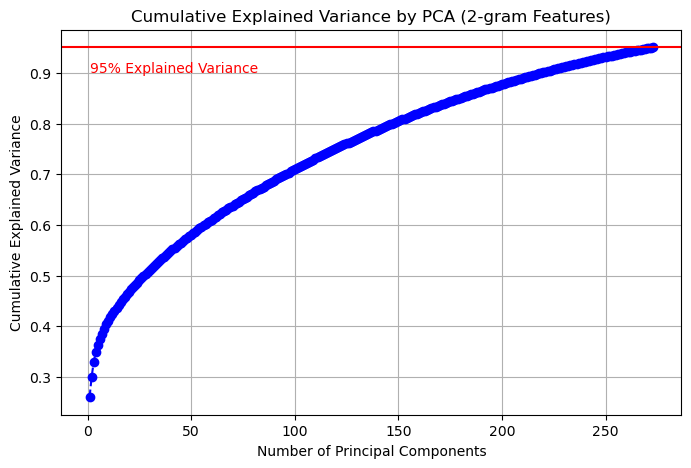

In [ ]:
# Calculate cumulative explained variance
cum_explained_variance = np.cumsum(pca_2gram.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_explained_variance) + 1), cum_explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA (2-gram Features)')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(1, 0.90, '95% Explained Variance', color='red')
plt.grid(True)
plt.show()


##### KNeighborsClassifier

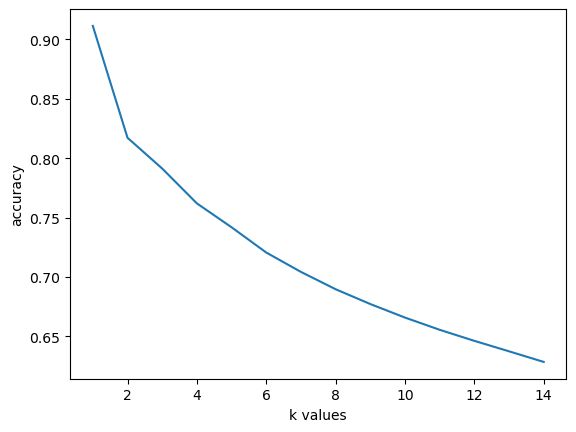

In [ ]:
# Finding k values in range(1,15)
score_list = []
for each in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = each)
    knn.fit(X_train_2, y_training)
    score_list.append(knn.score(X_train_2, y_training))

plt.plot(range(1,15),score_list)
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.show()

In [1]:
# KNeighborsClassifier
# It took approximately 6 hours to train the model
params_knn = {'n_neighbors': list(range(2,10)),
         'weights': ['uniform', 'distance'],
         'leaf_size': list(range(10,20))
        }
knn2 = KNeighborsClassifier()
gs_knn2 = RandomizedSearchCV(knn2, param_distributions=params_knn, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
gs_knn2.fit(X_train_pca_2, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_knn2.best_params_)
print('Best score found:\n', gs_knn2.best_score_)

Best parameters found:
 {'weights': 'distance', 'n_neighbors': 4, 'leaf_size': 16}
Best score found:
 0.5882134912891185



In [ ]:
# Extract the results
results = gs_knn2.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Accuracy: 0.588 ± 0.123
F1 Score (weighted): 0.583 ± 0.115
F1 Score (macro): 0.450 ± 0.108


In [ ]:
best_knn2 = gs_knn2.best_estimator_
best_knn2

KNeighborsClassifier(leaf_size=16, n_neighbors=4, weights='distance')

In [ ]:
knn_pred2 = best_knn2.predict(X_test_pca_2)
acc_knn2 = accuracy_score(knn_pred2, y_testing)
print(f'accuracy: {acc_knn2:.2f}')
f1_knn2 = f1_score(y_testing, knn_pred2, average='weighted')
print(f'f1 score: {f1_knn2:.2f}')
macro_f1_knn2 = f1_score(y_testing, knn_pred2, average='macro')
print(f'Macro f1 score: {macro_f1_knn2:.2f}')

accuracy: 0.55
f1 score: 0.51
Macro f1 score: 0.44



In [ ]:
accuracy_list2 = []
f1_list2 = []
macro_f1_list2 = []

# accuracy_list2.append(acc_knn2)
# f1_list2.append(f1_knn2)
# macro_f1_list2.append(macro_f1_knn2)

accuracy_list2.append(0.55)
f1_list2.append(0.51)
macro_f1_list2.append(0.44)


##### MultinomialNB

In [ ]:
# Naive Bayes Model
# It took approximately 2-3 hours to train the model
params_nb = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0],
        }
nb2 = MultinomialNB()
gs_nb2 = RandomizedSearchCV(nb2, param_distributions=params_nb, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
gs_nb2.fit(X_train_2, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_nb2.best_params_)
print('Best score found:\n', gs_nb2.best_score_)


Best parameters found:
 {'alpha': 0.001}
Best score found:
 0.20842619698646656


In [ ]:
best_nb2 = gs_nb2.best_estimator_
best_nb2

MultinomialNB(alpha=0.001)

In [ ]:
NB_pred2 = best_nb2.predict(X_test_2)
acc_nb2 = accuracy_score(NB_pred2, y_testing)
print(f'accuracy: {acc_nb2:.2f}')
f1_nb2 = f1_score(y_testing, NB_pred2, average='weighted')
print(f'f1 score: {f1_nb2:.2f}')
macro_f1_nb2 = f1_score(y_testing, NB_pred2, average='macro')
print(f'Macro f1 score: {macro_f1_nb2:.2f}')

accuracy: 0.19
f1 score: 0.19
Macro f1 score: 0.18



In [ ]:
accuracy_list2.append(0.19)
f1_list2.append(0.19)
macro_f1_list2.append(0.18)

##### Logistic Regression

In [ ]:
# Logistic Regression Classifier
# It took approximately 7-8 hours to train the model
params_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 1.0, 5.0],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
}

logreg2 = LogisticRegression(max_iter=300, class_weight = 'balanced', random_state=random_seed, verbose = 0, n_jobs = -1)
gs_lr2 = RandomizedSearchCV(logreg2, param_distributions=params_lr, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_lr2.fit(X_train_pca_2, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_lr2.best_params_)
print('Best score found:\n', gs_lr2.best_score_)

python(8407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best parameters found:
 {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}
Best score found:
 0.21879702834880912


In [ ]:
best_lr2 = gs_lr2.best_estimator_
best_lr2

LogisticRegression(class_weight='balanced', max_iter=300, n_jobs=-1,
                   random_state=42, solver='newton-cg')

In [ ]:
best_lr2 = gs_lr2.best_estimator_
lr_pred2 = best_lr2.predict(X_test_pca_2)
acc_lr2 = accuracy_score(lr_pred2, y_testing)
print('accuracy: %s' % acc_lr2)
f1_lr2 = f1_score(y_testing, lr_pred2, average='weighted')
print('f1 score: %s' % f1_lr2)
macro_f1_lr2 = f1_score(y_testing, lr_pred2, average='macro')

accuracy: 0.19
f1 score: 0.17
Macro f1 score: 0.13



In [ ]:
accuracy_list2.append(0.19)
f1_list2.append(0.17)
macro_f1_list2.append(0.13)

##### MLP Classifier

In [2]:
# MLPClassifier
# It took approximately 6-7 hours to train the model
params_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100,100,100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['invscaling','constant','adaptive'],
}

mlp2 = MLPClassifier(max_iter=300, activation='relu', solver='adam', random_state=random_seed)
gs_mlp2 = RandomizedSearchCV(mlp2, param_distributions=params_mlp, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_mlp2.fit(X_train_pca_2, y_training)

# Best paramete set
print('Best parameters found:\n', gs_mlp2.best_params_)
print('Best score found:\n', gs_mlp2.best_score_)

Best parameters found:
 {'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.01}
Best score found:
 0.5138861196323471



In [ ]:
best_mlp2 = gs_mlp2.best_estimator_
best_mlp2

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 100, 100),
              learning_rate='invscaling', max_iter=300, random_state=42)

In [ ]:
mlp_pred2 = best_mlp2.predict(X_test_pca_2)
acc_mlp2 = accuracy_score(mlp_pred2, y_testing)
print(f'accuracy: {acc_mlp2:.2f}')
f1_mlp2 = f1_score(y_testing, mlp_pred2, average='weighted')
print(f'f1 score: {f1_mlp2:.2f}')
macro_f1_mlp2 = f1_score(y_testing, mlp_pred2, average='macro')
print(f'Macro f1 score: {macro_f1_mlp2:.2f}')

accuracy: 0.46
f1 score: 0.44
Macro f1 score: 0.38



In [ ]:
accuracy_list2.append(0.46)
f1_list2.append(0.44)
macro_f1_list2.append(0.38)

##### Decision Tree Classifier

In [ ]:
#Decision Tree Classifier
# It took approximately 5-6 hours to train the model
params_dtc = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
}

dtc2 = DecisionTreeClassifier(min_samples_split=2, class_weight = 'balanced', random_state=random_seed)
gs_dtc2 = RandomizedSearchCV(dtc2, param_distributions=params_dtc, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_dtc2.fit(X_train_pca_2, y_training)
# Best paramete set
print('Best parameters found:\n', gs_dtc2.best_params_)
print('Best score found:\n', gs_dtc2.best_score_)

python(50228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best parameters found:
 {'splitter': 'best', 'criterion': 'gini'}
Best score found:
 0.46559554181582735


In [ ]:
best_dtc2 = gs_dtc2.best_estimator_
best_dtc2

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [ ]:
dtc_pred2 = best_dtc2.predict(X_test_pca_2)
acc_dtc2 = accuracy_score(dtc_pred2, y_testing)
print(f'accuracy: {acc_dtc2:.2f}')
f1_dtc2 = f1_score(y_testing, dtc_pred2, average='weighted')
print(f'f1 score: {f1_dtc2:.2f}')
macro_f1_dtc2 = f1_score(y_testing, dtc_pred2, average='macro')
print(f'Macro f1 score: {macro_f1_dtc2:.2f}')

accuracy: 0.42
f1 score: 0.40
Macro f1 score: 0.28



In [ ]:
accuracy_list2.append(0.42)
f1_list2.append(0.40)
macro_f1_list2.append(0.28)

##### Random Forest Classifier

In [ ]:
#Random Forest Classifier
# It took approximately 5-6 hours to train the model
params_rfc = {
    'n_estimators': [10,20,30,40,50,100],
    'criterion': ['gini', 'entropy'],

}

rfc2 = RandomForestClassifier(min_samples_split = 2, class_weight = 'balanced', verbose = 0, random_state=random_seed)
gs_rfc2 = RandomizedSearchCV(rfc2, param_distributions=params_rfc, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_rfc2.fit(X_train_pca_2, y_training)
# Best paramete set
print('Best parameters found:\n', gs_rfc2.best_params_)
print('Best score found:\n', gs_rfc2.best_score_)

python(54780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54782) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54784) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best parameters found:
 {'n_estimators': 100, 'criterion': 'entropy'}
Best score found:
 0.5589925021340826


In [ ]:
best_rfc2 = gs_rfc2.best_estimator_
best_rfc2

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       random_state=42)

In [ ]:
rfc_pred2 = best_rfc2.predict(X_test_pca_2)
acc_rfc2 = accuracy_score(rfc_pred2, y_testing)
print(f'accuracy: {acc_rfc2:.2f}')
f1_rfc2 = f1_score(y_testing, rfc_pred2, average='weighted')
print(f'f1 score: {f1_rfc2:.2f}')
macro_f1_rfc2 = f1_score(y_testing, rfc_pred2, average='macro')
print(f'Macro f1 score: {macro_f1_rfc2:.2f}')

accuracy: 0.52
f1 score: 0.50
Macro f1 score: 0.46



In [ ]:
accuracy_list2.append(0.52)
f1_list2.append(0.50)
macro_f1_list2.append(0.46)

##### XGBoost Classifier

In [3]:
#XGBoost Classifier
# It took approximately 5-6 hours to train the model
params_xgb = {
    'n_estimators': [100,200,300, 400,500],
    'max_depth': [3, 5, 7],  # maximum depth for each tree
    'learning_rate': [0.001, 0.01, 0.1]
}

xgb2 = XGBClassifier(booster = 'gbtree', gamma = 0.1, tree_method = 'hist', random_state=random_seed)
gs_xgb2 = RandomizedSearchCV(xgb2, param_distributions=params_xgb, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_xgb2.fit(X_train_pca_2, y_training)

# Best paramete set
print('Best parameters found:\n', gs_xgb2.best_params_)
print('Best score found:\n', gs_xgb2.best_score_)

Best parameters found:
 {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1}
Best score found:
 0.5921176075609876



In [ ]:
# Extract the results
results = gs_xgb2.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Accuracy: 0.592 ± 0.112
F1 Score (weighted): 0.578 ± 0.112
F1 Score (macro): 0.464 ± 0.100


In [ ]:
best_xgb2 = gs_xgb2.best_estimator_
best_xgb2

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
xgb_pred2 = best_xgb2.predict(X_test_pca_2)
acc_xgb2 = accuracy_score(xgb_pred2, y_testing)
print(f'accuracy: {acc_xgb2:.2f}')
f1_xgb2 = f1_score(y_testing, xgb_pred2, average='weighted')
print(f'f1 score: {f1_xgb2:.2f}')
macro_f1_xgb2 = f1_score(y_testing, xgb_pred2, average='macro')
print(f'Macro f1 score: {macro_f1_xgb2:.2f}')

accuracy: 0.56
f1 score: 0.54
Macro f1 score: 0.44



In [ ]:
accuracy_list2.append(0.56)
f1_list2.append(0.54)

macro_f1_list2.append(0.44)

##### Voting Classifier

In [ ]:
# group / ensemble of models
estimator2 = []
estimator2.append(('RFC', RandomForestClassifier(n_estimators = 100, min_samples_split = 2, criterion = 'entropy', verbose = 0, class_weight = 'balanced', random_state=random_seed, n_jobs = -1)))
estimator2.append(('KNN', KNeighborsClassifier(n_neighbors=4, leaf_size = 16, weights = 'distance', n_jobs = -1)))
estimator2.append(('XGB', XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1)))

In [ ]:
# Voting Classifier with soft voting
# It took approximately 5-6 hours to train the model
vot_soft2 = VotingClassifier(estimators = estimator2, voting ='soft', n_jobs = -1)
vot_soft2.fit(X_train_pca_2, y_training)
vots_pred2 = vot_soft2.predict(X_test_pca_2)

# using accuracy_score metric to predict accuracy and f1_score to predict f1 score
acc_vots2 = accuracy_score(y_testing, vots_pred2)
print(f'accuracy: {acc_vots2:.2f}')
f1_vots2 = f1_score(y_testing, vots_pred2, average='weighted')
print(f'f1 score: {f1_vots2:.2f}')
macro_f1_vots2 = f1_score(y_testing, vots_pred2, average='macro')
print(f'Macro f1 score: {macro_f1_vots2:.2f}')

accuracy: 0.58
f1 score: 0.55
Macro f1 score: 0.49



In [ ]:
accuracy_list2.append(0.58)
f1_list2.append(0.55)

macro_f1_list2.append(0.49)

##### Stacking Classifier

In [ ]:
# It took approximately 5-6 hours to train the model
meta_model2 = StackingClassifier(
    estimators=[
        ('KNN', KNeighborsClassifier(n_neighbors=4, leaf_size = 16, weights = 'distance', n_jobs = -1)),
        ('RFC', RandomForestClassifier(n_estimators = 100, min_samples_split = 2, criterion = 'entropy', verbose = 0, class_weight = 'balanced', random_state=random_seed, n_jobs = -1)),
        ('XGB', XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1))
    ],
    final_estimator=XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1), # LogisticRegression(solver = 'newton-cg', penalty = 'l2', class_weight = 'balanced', C = 1.0, random_state=random_seed, verbose = 1, n_jobs = -1)
    stack_method = 'auto',
    cv = 3,
    n_jobs = -1
)
meta_model2.fit(X_train_pca_2, y_training)

StackingClassifier(cv=3,
                   estimators=[('KNN',
                                KNeighborsClassifier(leaf_size=16, n_jobs=-1,
                                                     n_neighbors=4,
                                                     weights='distance')),
                               ('RFC',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_by...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=500, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...),
                   n_jobs=-1)

In [ ]:
meta_pred2 = meta_model2.predict(X_test_pca_2)
# using accuracy_score
acc_meta2 = accuracy_score(y_testing, meta_pred2)
print(f'accuracy: {acc_meta2:.2f}')
f1_meta2 = f1_score(y_testing, meta_pred2, average='weighted')
print(f'f1 score: {f1_meta2:.2f}')
macro_f1_meta2 = f1_score(y_testing, meta_pred2, average='macro')
print(f'Macro f1 score: {macro_f1_meta2:.2f}')

accuracy: 0.58
f1 score: 0.55
Macro f1 score: 0.48



In [ ]:
accuracy_list2.append(0.58)
f1_list2.append(0.55)

macro_f1_list2.append(0.48)

#### USING 3-GRAMS

In [ ]:
# Create a Count Vectorizer to gather the unique elements in sequence
vect_3 = CountVectorizer(analyzer = 'char', ngram_range = (3,3))      # using 3-grams

# Fit and Transform CountVectorizer
vect_3.fit(X_training)
X_train_3 = vect_3.transform(X_training)
X_test_3 = vect_3.transform(X_testing)


In [ ]:
X_train_3[0]

<1x8000 sparse matrix of type '<class 'numpy.int64'>'
	with 275 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_3[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [ ]:
vect_3.get_feature_names_out()

array(['aaa', 'aac', 'aad', ..., 'yyv', 'yyw', 'yyy'], dtype=object)

In [ ]:
pca_3gram = PCA(n_components=0.95)
X_train_pca_3 = pca_3gram.fit_transform(X_train_3.toarray())
X_test_pca_3 = pca_3gram.transform(X_test_3.toarray())

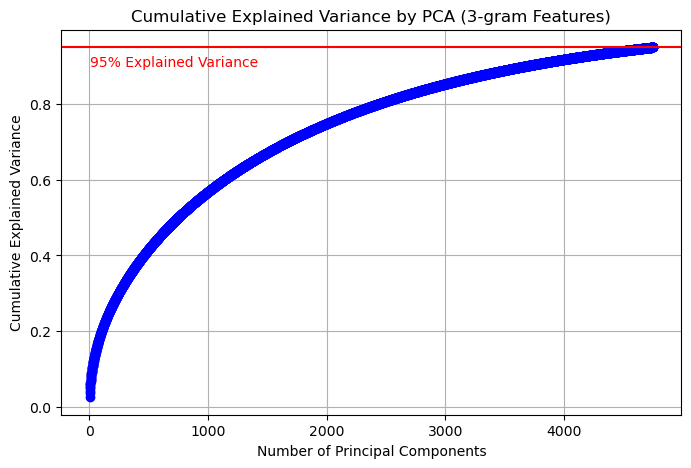

In [ ]:
# Calculate cumulative explained variance
cum_explained_variance = np.cumsum(pca_3gram.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_explained_variance) + 1), cum_explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA (3-gram Features)')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(1, 0.90, '95% Explained Variance', color='red')
plt.grid(True)
plt.show()

##### KNeighborsClassifier

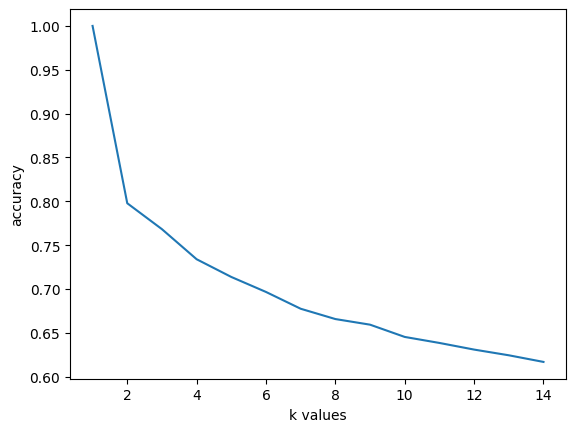

In [ ]:
# Findind k values in range(1,15)
score_list = []
for each in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = each)
    knn.fit(X_train_3, y_training)
    score_list.append(knn.score(X_train_3, y_training))

plt.plot(range(1,15),score_list)
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# KNeighborsClassifier
# It took approximately 9-10 hours to train the model
params_knn = {'n_neighbors': list(range(2,10)),
         'weights': ['uniform', 'distance'],
         'leaf_size': list(range(10,20))
        }

knn3 = KNeighborsClassifier()
gs_knn3 = RandomizedSearchCV(knn3, param_distributions=params_knn, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
gs_knn3.fit(X_train_pca_3, y_training)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'leaf_size': [13], 'n_neighbors': [3],
                                        'weights': ['distance']},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring={'accuracy': 'accuracy',
                            'f1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                            'f1_weighted': make_scorer(f1_score, response_method='predict', average=weighted)})

In [ ]:
print('Best parameters found:\n', gs_knn3.best_params_)
print('Best score found:\n', gs_knn3.best_score_)

Best parameters found:
 {'weights': 'distance', 'n_neighbors': 3, 'leaf_size': 13}
Best score found:
 0.5521117954716167


In [ ]:
# Extract the results
results = gs_knn3.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Accuracy: 0.552 ± 0.144
F1 Score (weighted): 0.572 ± 0.126
F1 Score (macro): 0.469 ± 0.095


In [ ]:
best_knn3 = gs_knn3.best_estimator_
best_knn3

KNeighborsClassifier(leaf_size=13, n_neighbors=3, weights='distance')

In [ ]:
knn_pred3 = best_knn3.predict(X_test_pca_3)
acc_knn3 = accuracy_score(knn_pred3, y_testing)
print(f'accuracy: {acc_knn3:.2f}')
f1_knn3 = f1_score(y_testing, knn_pred3, average='weighted')
print(f'f1 score: {f1_knn3:.2f}')
macro_f1_knn3 = f1_score(y_testing, knn_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_knn3:.2f}')

accuracy: 0.52
f1 score: 0.51
Macro f1 score: 0.44



In [ ]:
accuracy_list3 = []
f1_list3 = []
macro_f1_list3 = []

# accuracy_list3.append(acc_knn3)
# f1_list3.append(f1_knn3)
# macro_f1_list3.append(macro_f1_knn3)

accuracy_list3.append(0.52)
f1_list3.append(0.51)
macro_f1_list3.append(0.44)

##### MultinomialNB

In [ ]:
# Naive Bayes Model
# It took approximately 7-8 hours to train the model
params_nb = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0],
        }
nb3 = MultinomialNB()
gs_nb3 = RandomizedSearchCV(nb3, param_distributions=params_nb, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
gs_nb3.fit(X_train_3, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_nb3.best_params_)
print('Best score found:\n', gs_nb3.best_score_)

Best parameters found:
 {'alpha': 0.001}
Best score found:
 0.4043347765264007


In [ ]:
best_nb3 = gs_nb3.best_estimator_
best_nb3

MultinomialNB(alpha=0.001)

In [ ]:
NB_pred3 = best_nb3.predict(X_test_3)
acc_nb3 = accuracy_score(NB_pred3, y_testing)
print(f'accuracy: {acc_nb3:.2f}')
f1_nb3 = f1_score(y_testing, NB_pred3, average='weighted')
print(f'f1 score: {f1_nb3:.2f}')
macro_f1_nb3 = f1_score(y_testing, NB_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_nb3:.2f}')

accuracy: 0.39
f1 score: 0.38
Macro f1 score: 0.30



In [ ]:
accuracy_list3.append(0.39)
f1_list3.append(0.38)
macro_f1_list3.append(0.30)

##### Logistic Regression

In [4]:
# Logistic Regression Classifier
# It took approximately 7-8 hours to train the model
params_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 1.0, 5.0],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],

}

logreg3 = LogisticRegression(penalty = 'l2', max_iter=300, class_weight = 'balanced', random_state=random_seed, verbose = 0, n_jobs = -1)
gs_lr3 = RandomizedSearchCV(logreg3, param_distributions=params_lr, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_lr3.fit(X_train_pca_3, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_lr3.best_params_)
print('Best score found:\n', gs_lr3.best_score_)

Best parameters found:
 {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}
Best score found:
 0.5309059386311313



In [ ]:
best_lr3 = gs_lr3.best_estimator_
best_lr3

LogisticRegression(class_weight='balanced', max_iter=300, n_jobs=-1,
                   random_state=42, solver='newton-cg')

In [ ]:
lr_pred3 = best_lr3.predict(X_test_pca_3)
acc_lr3 = accuracy_score(lr_pred3, y_testing)
print(f'accuracy: {acc_lr3:.2f}')
f1_lr3 = f1_score(y_testing, lr_pred3, average='weighted')
print(f'f1 score: {f1_lr3:.2f}')
macro_f1_lr3 = f1_score(y_testing, lr_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_lr3:.2f}')

accuracy: 0.50
f1 score: 0.48
Macro f1 score: 0.44



In [ ]:
accuracy_list3.append(0.50)
f1_list3.append(0.48)
macro_f1_list3.append(0.44)

##### MLP Classifier

In [5]:
# MLPClassifier
# It took approximately 7-8 hours to train the model
params_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100,100,100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['invscaling','constant','adaptive']
}

mlp3 = MLPClassifier(max_iter=300, activation='relu', solver='adam', random_state=random_seed)
gs_mlp3 = RandomizedSearchCV(mlp3, param_distributions=params_mlp, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_mlp3.fit(X_train_pca_3, y_training)
# Best paramete set
print('Best parameters found:\n', gs_mlp3.best_params_)
print('Best score found:\n', gs_mlp3.best_score_)

Best parameters found:
 {'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,), 'alpha': 0.001}
Best score found:
 0.5882012835166902



In [ ]:
best_mlp3 = gs_mlp3.best_estimator_
best_mlp3

MLPClassifier(alpha=0.001, learning_rate='invscaling', max_iter=300,
              random_state=42)

In [ ]:
mlp_pred3 = best_mlp3.predict(X_test_pca_3)
acc_mlp3 = accuracy_score(mlp_pred3, y_testing)
print(f'accuracy: {acc_mlp3:.2f}')
f1_mlp3 = f1_score(y_testing, mlp_pred3, average='weighted')
print(f'f1 score: {f1_mlp3:.2f}')
macro_f1_mlp3 = f1_score(y_testing, mlp_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_mlp3:.2f}')

accuracy: 0.50
f1 score: 0.49
Macro f1 score: 0.42



In [ ]:
accuracy_list3.append(0.50)
f1_list3.append(0.49)
macro_f1_list3.append(0.42)

##### Decision Tree Classifier

In [6]:
#Decision Tree Classifier
# It took approximately 7-8 hours to train the model
params_dtc = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random']
}

dtc3 = DecisionTreeClassifier(min_samples_split=2, class_weight = 'balanced', random_state=random_seed)
gs_dtc3 = RandomizedSearchCV(dtc3, param_distributions=params_dtc, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_dtc3.fit(X_train_pca_3, y_training)
# Best paramete set
print('Best parameters found:\n', gs_dtc3.best_params_)
print('Best score found:\n', gs_dtc3.best_score_)

Best parameters found:
 {'splitter': 'random', 'criterion': 'gini'}
Best score found:
 0.5149478144523627



In [ ]:
best_dtc3 = gs_dtc3.best_estimator_
best_dtc3

DecisionTreeClassifier(class_weight='balanced', random_state=42,
                       splitter='random')

In [ ]:
dtc_pred3 = best_dtc3.predict(X_test_pca_3)
acc_dtc3 = accuracy_score(dtc_pred3, y_testing)
print(f'accuracy: {acc_dtc3:.2f}')
f1_dtc3 = f1_score(y_testing, dtc_pred3, average='weighted')
print(f'f1 score: {f1_dtc3:.2f}')
macro_f1_dtc3 = f1_score(y_testing, dtc_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_dtc3:.2f}')

accuracy: 0.47
f1 score: 0.45
Macro f1 score: 0.37



In [ ]:
accuracy_list3.append(0.47)
f1_list3.append(0.45)
macro_f1_list3.append(0.37)

##### Random Forest Classifier

In [ ]:
#Random Forest Classifier
# It took approximately 8-9 hours to train the model
params_rfc = {
    'n_estimators': [10,20,30,40,50,100],
    'criterion': ['gini', 'entropy']
}

rfc3 = RandomForestClassifier(min_samples_split = 2, class_weight = 'balanced', verbose = 0, random_state=random_seed)
gs_rfc3 = RandomizedSearchCV(rfc3, param_distributions=params_rfc, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_rfc3.fit(X_train_pca_3, y_training)
# Best paramete set
print('Best parameters found:\n', gs_rfc3.best_params_)
print('Best score found:\n', gs_rfc3.best_score_)

Best parameters found:
 {'n_estimators': 100, 'criterion': 'gini'}
Best score found:
 0.5563815576606728



In [ ]:
best_rfc3 = gs_rfc3.best_estimator_
best_rfc3

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
rfc_pred3 = best_rfc3.predict(X_test_pca_3)
acc_rfc3 = accuracy_score(rfc_pred3, y_testing)
print(f'accuracy: {acc_rfc3:.2f}')
f1_rfc3 = f1_score(y_testing, rfc_pred3, average='weighted')
print(f'f1 score: {f1_rfc3:.2f}')
macro_f1_rfc3 = f1_score(y_testing, rfc_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_rfc3:.2f}')

accuracy: 0.52
f1 score: 0.50
Macro f1 score: 0.48



In [ ]:
accuracy_list3.append(0.52)
f1_list3.append(0.50)
macro_f1_list3.append(0.48)

##### XGBoost Classifier

In [ ]:
#XGBoost Classifier
# It took approximately 9-10 hours to train the model

params_xgb = {
    'n_estimators': [500], #[100,200,300, 400,500],
    'max_depth': [7], # [3, 5, 7],
    'learning_rate':[0.1], #[0.001, 0.01, 0.1]
}

xgb3 = XGBClassifier(booster = 'gbtree', gamma = 0.1, tree_method = 'hist', random_state=random_seed)
gs_xgb3 = RandomizedSearchCV(xgb3, param_distributions=params_xgb, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_xgb3.fit(X_train_pca_3, y_training)
# Best paramete set
print('Best parameters found:\n', gs_xgb3.best_params_)
print('Best score found:\n', gs_xgb3.best_score_)

Best parameters found:
 {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1}
Best score found:
 0.5887868435046638


In [ ]:
best_xgb3 = gs_xgb3.best_estimator_
best_xgb3

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
xgb_pred3 = best_xgb3.predict(X_test_pca_3)
acc_xgb3 = accuracy_score(xgb_pred3, y_testing)
print(f'accuracy: {acc_xgb3:.2f}')
f1_xgb3 = f1_score(y_testing, xgb_pred3, average='weighted')
print(f'f1 score: {f1_xgb3:.2f}')
macro_f1_xgb3 = f1_score(y_testing, xgb_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_xgb3:.2f}')

accuracy: 0.56
f1 score: 0.55
Macro f1 score: 0.49



In [ ]:
accuracy_list3.append(0.56)
f1_list3.append(0.55)

macro_f1_list3.append(0.49)

##### Voting Classifier

In [ ]:
# group / ensemble of models
estimator3 = []
estimator3.append(('RFC', RandomForestClassifier(n_estimators = 100, min_samples_split = 2, criterion = 'entropy', verbose = 0, class_weight = 'balanced', random_state=random_seed, n_jobs = -1)))
estimator3.append(('KNN', KNeighborsClassifier(n_neighbors=5, leaf_size = 13, weights = 'distance', n_jobs = -1)))
estimator3.append(('XGB', XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1)))

In [ ]:
# Voting Classifier with soft voting
# It took approximately 9-10 hours to train the model
vot_soft3 = VotingClassifier(estimators = estimator3, voting ='soft', n_jobs = -1)
vot_soft3.fit(X_train_pca_3, y_training)
vots_pred3 = vot_soft3.predict(X_test_pca_3)

# using accuracy_score metric to predict accuracy and f1_score to predict f1 score
acc_vots3 = accuracy_score(y_testing, vots_pred3)
print(f'accuracy: {acc_vots3:.2f}')
f1_vots3 = f1_score(y_testing, vots_pred3, average='weighted')
print(f'f1 score: {f1_vots3:.2f}')
macro_f1_vots3 = f1_score(y_testing, vots_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_vots3:.2f}')

accuracy: 0.60
f1 score: 0.56
Macro f1 score: 0.51



In [ ]:
accuracy_list3.append(0.60)
f1_list3.append(0.56)

macro_f1_list3.append(0.51)

##### Stacking Classifier

In [ ]:
# It took approximately 9-10 hours to train the model
meta_model3 = StackingClassifier(
    estimators=[
        ('KNN', KNeighborsClassifier(n_neighbors=3, leaf_size = 13, weights = 'distance', n_jobs = -1)),
        ('RFC', RandomForestClassifier(n_estimators = 100, min_samples_split = 2, criterion = 'entropy', verbose = 1, class_weight = 'balanced', random_state=random_seed, n_jobs = -1)),
        ('XGB', XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1))
    ],
    final_estimator=XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1),
    stack_method = 'auto',
    cv = 3,
    n_jobs = -1
)
meta_model3.fit(X_train_pca_3, y_training)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 54.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 54.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 54.6min finished
[Parallel(n_jobs=1)]: Usi

StackingClassifier(cv=3,
                   estimators=[('KNN',
                                KNeighborsClassifier(leaf_size=13, n_jobs=-1,
                                                     n_neighbors=3,
                                                     weights='distance')),
                               ('RFC',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       n_jobs=-1,
                                                       random_state=42,
                                                       verbose=1)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              co...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=500, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=42, ...),
                   n_jobs=-1)

In [ ]:
meta_pred3 = meta_model3.predict(X_test_pca_3)
# using accuracy_score
acc_meta3 = accuracy_score(y_testing, meta_pred3)
print(f'accuracy: {acc_meta3:.2f}')
f1_meta3 = f1_score(y_testing, meta_pred3, average='weighted')
print(f'f1 score: {f1_meta3:.2f}')
macro_f1_meta3 = f1_score(y_testing, meta_pred3, average='macro')
print(f'Macro f1 score: {macro_f1_meta3:.2f}')

accuracy: 0.61
f1 score: 0.56
Macro f1 score: 0.50



In [ ]:
accuracy_list3.append(0.61)
f1_list3.append(0.56)

macro_f1_list3.append(0.50)

#### USING 4-GRAMS

In [ ]:
# Create a Count Vectorizer to gather the unique elements in sequence
vect_4 = CountVectorizer(analyzer = 'char', ngram_range = (4,4))      # using 4-grams

# Fit and Transform CountVectorizer
vect_4.fit(X_training)
X_train_4 = vect_4.transform(X_training)
X_test_4 = vect_4.transform(X_testing)


In [ ]:
X_train_4[0]

<1x159230 sparse matrix of type '<class 'numpy.int64'>'
	with 284 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_4[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [ ]:
vect_4.get_feature_names_out()

array(['aaaa', 'aaac', 'aaad', ..., 'yyyv', 'yyyw', 'yyyy'], dtype=object)

In [ ]:
pca_4gram = PCA(n_components=5000)
X_train_pca_4 = pca_4gram.fit_transform(X_train_4.toarray())
X_test_pca_4 = pca_4gram.transform(X_test_4.toarray())

In [ ]:
# Calculate cumulative explained variance
cum_explained_variance = np.cumsum(pca_4gram.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_explained_variance) + 1), cum_explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA (4-gram Features)')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(1, 0.90, '95% Explained Variance', color='red')
plt.grid(True)
plt.show()

##### KNeighborsClassifier

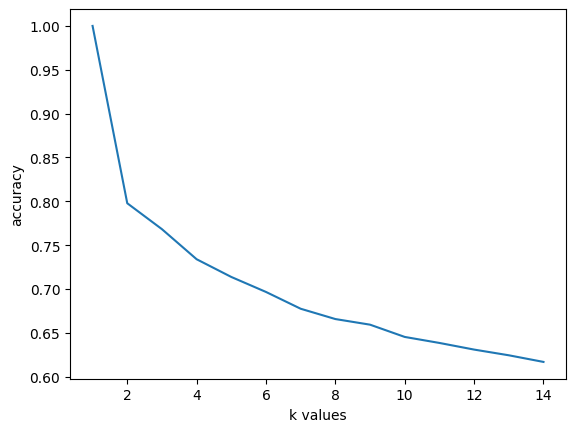

In [ ]:
# Findind k values in range(1,15)
score_list = []
for each in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = each)
    knn.fit(X_train_4, y_training)
    score_list.append(knn.score(X_train_4, y_training))

plt.plot(range(1,15),score_list)
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# KNeighborsClassifier
# It took approximately 28 hours to train the model
params_knn = {'n_neighbors':list(range(2,10)),
         'weights': ['uniform', 'distance'],
         'leaf_size': list(range(10,20))
        }
knn4 = KNeighborsClassifier()
gs_knn4 = RandomizedSearchCV(knn4, param_distributions=params_knn, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
gs_knn4.fit(X_train_4, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_knn4.best_params_)
print('Best score found:\n', gs_knn4.best_score_)

Best parameters found:
 {'weights': 'distance', 'n_neighbors': 3, 'leaf_size': 13}
Best score found:
 0.5815736329322557



In [ ]:
# Extract the results
results = gs_knn4.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()

print(f"Train Accuracy (mean ± std): {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"Train F1 Score (weighted) (mean ± std): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"Train F1 Score (macro) (mean ± std): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Train Accuracy (mean ± std): 0.582 ± 0.156
Train F1 Score (weighted) (mean ± std): 0.561 ± 0.124
Train F1 Score (macro) (mean ± std): 0.494 ± 0.090



In [ ]:
best_knn4 = gs_knn4.best_estimator_
best_knn4

KNeighborsClassifier(leaf_size=13, n_neighbors=3, weights='distance')

In [ ]:
knn_pred4 = best_knn4.predict(X_test_4)
acc_knn4 = accuracy_score(knn_pred4, y_testing)
print(f'accuracy: {acc_knn4:.2f}')
f1_knn4 = f1_score(y_testing, knn_pred4, average='weighted')
print(f'f1 score: {f1_knn4:.2f}')
macro_f1_knn4 = f1_score(y_testing, knn_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_knn4:.2f}')

accuracy: 0.54
f1 score: 0.52
Macro f1 score: 0.48



In [ ]:
accuracy_list4 = []
f1_list4 = []
macro_f1_list4 = []

# accuracy_list4.append(acc_knn4)
# f1_list4.append(f1_knn4)
# macro_f1_list4.append(macro_f1_knn4)

accuracy_list4.append(0.54)
f1_list4.append(0.52)
macro_f1_list4.append(0.48)

##### MultinomialNB

In [ ]:
# Naive Bayes Model
# It took approximately 28 hours to train the model
params_nb = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0],
        }
nb4 = MultinomialNB()
gs_nb4 = RandomizedSearchCV(nb4, param_distributions=params_nb, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
gs_nb4.fit(X_train_4, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_nb4.best_params_)
print('Best score found:\n', gs_nb4.best_score_)

Best parameters found:
 {'alpha': 1.0}
Best score found:
 0.4571886521237987



In [ ]:
# Extract the results
results = gs_nb4.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Train Accuracy (mean ± std): 0.457 ± 0.156
Train F1 Score (weighted) (mean ± std): 0.441 ± 0.124
Train F1 Score (macro) (mean ± std): 0.392 ± 0.090



In [ ]:
best_nb4 = gs_nb4.best_estimator_
best_nb4

MultinomialNB()

In [ ]:
NB_pred4 = best_nb4.predict(X_test_4)
acc_nb4 = accuracy_score(NB_pred4, y_testing)
print(f'accuracy: {acc_nb4:.2f}')
f1_nb4 = f1_score(y_testing, NB_pred4, average='weighted')
print(f'f1 score: {f1_nb4:.2f}')
macro_f1_nb4 = f1_score(y_testing, NB_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_nb4:.2f}')

accuracy: 0.43
f1 score: 0.42
Macro f1 score: 0.37



In [ ]:
accuracy_list4.append(0.43)
f1_list4.append(0.42)
macro_f1_list4.append(0.37)

##### Logistic Regression

In [ ]:
# Logistic Regression Classifier
# It took approximately 40 hours to train the model
params_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 1.0, 5.0],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
}

logreg4 = LogisticRegression(max_iter=300, class_weight = 'balanced', random_state=random_seed, verbose = 0, n_jobs = -1)
gs_lr4 = RandomizedSearchCV(logreg4, param_distributions=params_lr, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

# fit the model
gs_lr4.fit(X_train_4, y_training)
#See the best results:
# Best paramete set
print('Best parameters found:\n', gs_lr4.best_params_)
print('Best score found:\n', gs_lr4.best_score_)

Best parameters found:
 {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}
Best score found:
 0.594725184713084



In [ ]:
# Extract the results
results = gs_lr4.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")


Accuracy: 0.595 ± 0.003
F1 Score (weighted): 0.574 ± 0.003
F1 Score (macro): 0.502 ± 0.002



In [ ]:
best_lr4 = gs_lr4.best_estimator_
best_lr4

LogisticRegression(class_weight='balanced', max_iter=300, n_jobs=-1,
                   random_state=42, solver='newton-cg', verbose=1)

In [ ]:
lr_pred4 = best_lr4.predict(X_test_4)
acc_lr4 = accuracy_score(lr_pred4, y_testing)
print(f'accuracy: {acc_lr4:.2f}')
f1_lr4 = f1_score(y_testing, lr_pred4, average='weighted')
print(f'f1 score: {f1_lr4:.2f}')
macro_f1_lr4 = f1_score(y_testing, lr_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_lr4:.2f}')

accuracy: 0.56
f1 score: 0.54
Macro f1 score: 0.47



In [ ]:
accuracy_list4.append(0.56)
f1_list4.append(0.54)
macro_f1_list4.append(0.47)

##### MLP Classifier

In [ ]:
# MLPClassifier
# It took approximately 39-40 hours to train the model
params_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100,100,100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['invscaling','constant','adaptive'],
}

mlp4 = MLPClassifier(max_iter=300, activation='relu', solver='adam', random_state=random_seed)
gs_mlp4 = RandomizedSearchCV(mlp4, param_distributions=params_mlp, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)
# gs_mlp = GridSearchCV(mlp, params_mlp, cv=5)
gs_mlp4.fit(X_train_4, y_training)
# Best paramete set
print('Best parameters found:\n', gs_mlp4.best_params_)
print('Best score found:\n', gs_mlp4.best_score_)

Best parameters found:
 {'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,), 'alpha': 0.001}
Best score found:
 0.6212993853683732



In [ ]:
# Extract the results
results = gs_mlp4.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Accuracy: 0.621 ± 0.001
F1 Score (weighted): 0.605 ± 0.001
F1 Score (macro): 0.536 ± 0.006



In [ ]:
# best_mlp4 = MLPClassifier(alpha = 0.001, hidden_layer_sizes = (100,), max_iter=300, activation='relu', solver='adam', learning_rate = 'invscaling', random_state=random_seed)
# best_mlp4.fit(X_train_4, y_training)

best_mlp4 = gs_mlp4.best_estimator_
best_mlp4

MLPClassifier(alpha=0.001, learning_rate='invscaling', max_iter=300,
              random_state=42)

In [ ]:
mlp_pred4 = best_mlp4.predict(X_test_4)
acc_mlp4 = accuracy_score(mlp_pred4, y_testing)
print(f'accuracy: {acc_mlp4:.2f}')
f1_mlp4 = f1_score(y_testing, mlp_pred4, average='weighted')
print(f'f1 score: {f1_mlp4:.2f}')
macro_f1_mlp4 = f1_score(y_testing, mlp_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_mlp4:.2f}')

accuracy: 0.58
f1 score: 0.54
Macro f1 score: 0.47



In [ ]:
accuracy_list4.append(0.58)
f1_list4.append(0.54)

macro_f1_list4.append(0.47)

##### Decision Tree Classifier

In [ ]:
#Decision Tree Classifier
# It took approximately 40 hours to train the model
params_dtc = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
}

dtc4 = DecisionTreeClassifier(min_samples_split = 2, class_weight = 'balanced', random_state=random_seed)
gs_dtc4 = RandomizedSearchCV(dtc4, param_distributions=params_dtc, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_dtc4.fit(X_train_4, y_training)
# Best paramete set
print('Best parameters found:\n', gs_dtc4.best_params_)
print('Best score found:\n', gs_dtc4.best_score_)

Best parameters found:
 {'splitter': 'best', 'criterion': 'gini'}
Best score found:
 0.5544650392018172



In [ ]:
# Extract the results
results = gs_dtc4.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Accuracy: 0.554 ± 0.008
F1 Score (weighted): 0.534 ± 0.006
F1 Score (macro): 0.486 ± 0.005



In [ ]:
# best_dtc4 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', min_samples_split = 2, class_weight = 'balanced', random_state=random_seed)
# best_dtc4.fit(X_train_4, y_training)

best_dtc4 = gs_dtc4.best_estimator_
best_dtc4

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [ ]:
dtc_pred4 = best_dtc4.predict(X_test_4)
acc_dtc4 = accuracy_score(dtc_pred4, y_testing)
print(f'accuracy: {acc_dtc4:.2f}')
f1_dtc4 = f1_score(y_testing, dtc_pred4, average='weighted')
print(f'f1 score: {f1_dtc4:.2f}')
macro_f1_dtc4 = f1_score(y_testing, dtc_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_dtc4:.2f}')

accuracy: 0.52
f1 score: 0.50
Macro f1 score: 0.44



In [ ]:
accuracy_list4.append(0.52)
f1_list4.append(0.50)

macro_f1_list4.append(0.44)

##### Random Forest Classifier

In [ ]:
#Random Forest Classifier
# It took approximately 40 hours to train the model
params_rfc = {
    'n_estimators': [10,20,30,40,50,100],
     'criterion': ['gini', 'entropy'],
}

rfc4 = RandomForestClassifier(min_samples_split = 2, class_weight = 'balanced', verbose = 0, random_state=random_seed, n_jobs = -1)
gs_rfc4 = RandomizedSearchCV(rfc4, param_distributions=params_rfc, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_rfc4.fit(X_train_4, y_training)
# Best paramete set
print('Best parameters found:\n', gs_rfc4.best_params_)
print('Best score found:\n', gs_rfc4.best_score_)

Best parameters found:
 {'n_estimators': 100, 'criterion': 'gini'}
Best score found:
 0.6281448558309212



In [ ]:
# Extract the results
results = gs_rfc4.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Accuracy: 0.628 ± 0.001
F1 Score (weighted): 0.603 ± 0.002
F1 Score (macro): 0.587 ± 0.002



In [ ]:
best_rfc4 = gs_rfc4.best_estimator_
best_rfc4

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 82.3min finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42,
                       verbose=1)

In [ ]:
rfc_pred4 = best_rfc4.predict(X_test_4)
acc_rfc4 = accuracy_score(rfc_pred4, y_testing)
print(f'accuracy: {acc_rfc4:.2f}')
f1_rfc4 = f1_score(y_testing, rfc_pred4, average='weighted')
print(f'f1 score: {f1_rfc4:.2f}')
macro_f1_rfc4 = f1_score(y_testing, rfc_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_rfc4:.2f}')

accuracy: 0.58
f1 score: 0.55
Macro f1 score: 0.50



In [ ]:
accuracy_list4.append(0.58)
f1_list4.append(0.55)

macro_f1_list4.append(0.50)

##### XGB Classifier

In [ ]:
#XGBoost Classifier
# It took approximately 40 hours to train the model

params_xgb = {
    'n_estimators': [100,200,300, 400,500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1]
}

xgb4 = XGBClassifier(booster = 'gbtree', gamma = 0.1, tree_method = 'hist', random_state=random_seed, n_jobs = -1) # min_child_weight = 4,
gs_xgb4 = RandomizedSearchCV(xgb4, param_distributions=params_xgb, scoring=scoring, n_iter=50, cv=3, n_jobs = -1, random_state = random_seed, refit='accuracy', return_train_score=True)

gs_xgb4.fit(X_train_4, y_training)
# Best paramete set
print('Best parameters found:\n', gs_xgb4.best_params_)
print('Best score found:\n', gs_xgb4.best_score_)

Best parameters found:
 {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1}
Best score found:
 0.6386503809933757



In [ ]:
# Extract the results
results = gs_xgb4.cv_results_

# Calculate mean and std for accuracy
accuracy_mean = results['mean_test_accuracy'].mean()
accuracy_std = results['std_test_accuracy'].mean()

# Calculate mean and std for weighted F1 score
f1_mean = results['mean_test_f1_weighted'].mean()
f1_std = results['std_test_f1_weighted'].mean()

# Calculate mean and std for macro F1 score
f1_macro_mean = results['mean_test_f1_macro'].mean()
f1_macro_std = results['std_test_f1_macro'].mean()


print(f"Accuracy: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
print(f"F1 Score (weighted): {f1_mean:.3f} ± {f1_std:.3f}")
print(f"F1 Score (macro): {f1_macro_mean:.3f} ± {f1_macro_std:.3f}")

Accuracy: 0.638 ± 0.001
F1 Score (weighted): 0.614 ± 0.001
F1 Score (macro): 0.587 ± 0.002


In [ ]:
best_xgb4 = gs_xgb4.best_estimator_
best_xgb4

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
xgb_pred4 = best_xgb4.predict(X_test_4)
acc_xgb4 = accuracy_score(xgb_pred4, y_testing)
print(f'accuracy: {acc_xgb4:.2f}')
f1_xgb4 = f1_score(y_testing, xgb_pred4, average='weighted')
print(f'f1 score: {f1_xgb4:.2f}')
macro_f1_xgb4 = f1_score(y_testing, xgb_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_xgb4:.2f}')

accuracy: 0.59
f1 score: 0.56
Macro f1 score: 0.53



In [ ]:
accuracy_list4.append(0.59)
f1_list4.append(0.56)

macro_f1_list4.append(0.53)

##### Voting Classifier

In [ ]:
# group / ensemble of models
estimator4 = []
estimator4.append(('LR', LogisticRegression(solver = 'newton-cg', penalty = 'l2', class_weight = 'balanced', C = 1.0, random_state=random_seed, verbose = 0, n_jobs = -1)))
estimator4.append(('RFC', RandomForestClassifier(n_estimators = 100, min_samples_split = 2, criterion = 'gini', verbose = 0, class_weight = 'balanced', random_state=random_seed, n_jobs = -1)))
estimator4.append(('KNN', KNeighborsClassifier(n_neighbors=3, leaf_size = 13, weights = 'distance', n_jobs = -1)))
estimator4.append(('XGB', XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1)))



In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# It took approximately 5 days to train the model
vot_soft4 = VotingClassifier(estimators = estimator4, voting ='soft')

# Initialize StratifiedKFold for splitting the data
skf = StratifiedKFold(n_splits=10)

# Lists to store the scores
accuracy_scores = []
f1_scores_weighted = []
f1_scores_macro = []

# Perform cross-validation
for train_index, test_index in skf.split(X_train_4, y_training):
    X_train_fold, X_test_fold = X_train_4[train_index], X_train_4[test_index]
    y_train_fold, y_test_fold = y_training[train_index], y_training[test_index]

    # Fit the voting classifier on the training fold
    vot_soft4.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = vot_soft4.predict(X_test_fold)

    # Calculate accuracy and F1 score on the test fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    f1_weighted = f1_score(y_test_fold, y_pred_fold, average='weighted')
    f1_macro = f1_score(y_test_fold, y_pred_fold, average='macro')

    # Append the scores to the lists
    accuracy_scores.append(accuracy)
    f1_scores_weighted.append(f1_weighted)
    f1_scores_macro.append(f1_macro)

# Calculate mean and standard deviation for accuracy and F1 score
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
mean_f1_weighted = np.mean(f1_scores_weighted)
std_f1_weighted = np.std(f1_scores_weighted)
mean_f1_macro = np.mean(f1_scores_macro)
std_f1_macro = np.std(f1_scores_macro)

print(f"Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Accuracy (mean ± std): 0.666 ± 0.006
F1 Score (weighted) (mean ± std): 0.648 ± 0.003
F1 Score (macro) (mean ± std): 0.580 ± 0.009



In [ ]:
# Voting Classifier with soft voting
vot_soft4 = VotingClassifier(estimators = estimator4, voting ='soft')
vot_soft4.fit(X_train_4, y_training)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 471.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 73.4min finished


VotingClassifier(estimators=[('LR',
                              LogisticRegression(class_weight='balanced',
                                                 n_jobs=-1, random_state=42,
                                                 solver='newton-cg',
                                                 verbose=1)),
                             ('RFC',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_jobs=-1, random_state=42,
                                                     verbose=1)),
                             ('KNN',
                              KNeighborsClassifier(leaf_size=13, n_jobs=-1,
                                                   n_neighbors=3,
                                                   weights='distance')),
                             ('XGB',
                              XGBClassifier(base_score=None,...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...))],
                 voting='soft')

In [ ]:
vots_pred4 = vot_soft4.predict(X_test_4)
# using accuracy_score and f1_score
acc_vots4 = accuracy_score(y_testing, vots_pred4)
print(f'accuracy: {acc_vots4:.2f}')
f1_vots4 = f1_score(y_testing, vots_pred4, average='weighted')
print(f'f1 score: {f1_vots4:.2f}')
macro_f1_vots4 = f1_score(y_testing, vots_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_vots4:.2f}')

accuracy: 0.63
f1 score: 0.60
Macro f1 score: 0.53



In [ ]:
accuracy_list4.append(0.63)
f1_list4.append(0.60)

macro_f1_list4.append(0.53)

##### Stacking Classifier

In [ ]:
meta_model4 = StackingClassifier(
    estimators=[
        ('KNN', KNeighborsClassifier(n_neighbors=3, leaf_size = 13, weights = 'distance', n_jobs = -1)),
        ('RFC', RandomForestClassifier(n_estimators = 100, min_samples_split = 2, criterion = 'entropy', verbose = 0, class_weight = 'balanced', random_state=random_seed, n_jobs = -1)),
        ('XGB', XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1))
    ],
    final_estimator=XGBClassifier(booster = 'gbtree', n_estimators = 500, gamma = 0.1, max_depth = 7, tree_method = 'hist', learning_rate = 0.1, random_state=random_seed, n_jobs = -1), # LogisticRegression(solver = 'newton-cg', penalty = 'l2', class_weight = 'balanced', C = 1.0, random_state=random_seed, verbose = 1, n_jobs = -1)
    stack_method = 'auto',
    cv = 3,
    n_jobs = -1
)

In [ ]:
# It took approximately 5 days to train the model

# Initialize StratifiedKFold for splitting the data
skf = StratifiedKFold(n_splits=10)

# Lists to store the scores
accuracy_scores = []
f1_scores_weighted = []
f1_scores_macro = []

# Perform cross-validation
for train_index, test_index in skf.split(X_train_4, y_training):
    X_train_fold, X_test_fold = X_train_4[train_index], X_train_4[test_index]
    y_train_fold, y_test_fold = y_training[train_index], y_training[test_index]

    # Fit the voting classifier on the training fold
    meta_model4.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = meta_model4.predict(X_test_fold)

    # Calculate accuracy and F1 score on the test fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    f1_weighted = f1_score(y_test_fold, y_pred_fold, average='weighted')
    f1_macro = f1_score(y_test_fold, y_pred_fold, average='macro')

    # Append the scores to the lists
    accuracy_scores.append(accuracy)
    f1_scores_weighted.append(f1_weighted)
    f1_scores_macro.append(f1_macro)

# Calculate mean and standard deviation for accuracy and F1 score
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
mean_f1_weighted = np.mean(f1_scores_weighted)
std_f1_weighted = np.std(f1_scores_weighted)
mean_f1_macro = np.mean(f1_scores_macro)
std_f1_macro = np.std(f1_scores_macro)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 64.5min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 169.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 170.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 171.5min finished
[Parallel(n_jobs=1)]: 

In [ ]:
print(f"Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Accuracy (mean ± std): 0.638 ± 0.004
F1 Score (weighted) (mean ± std): 0.622 ± 0.005
F1 Score (macro) (mean ± std): 0.566 ± 0.008



In [ ]:
meta_model4.fit(X_train_4, y_training)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 74.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 207.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 208.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 210.4min finished
[Parallel(n_jobs=1)]: 

StackingClassifier(cv=3,
                   estimators=[('KNN',
                                KNeighborsClassifier(leaf_size=13, n_jobs=-1,
                                                     n_neighbors=3,
                                                     weights='distance')),
                               ('RFC',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       n_jobs=-1,
                                                       random_state=42,
                                                       verbose=1)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              co...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=500, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=42, ...),
                   n_jobs=-1)

In [ ]:
meta_pred4 = meta_model4.predict(X_test_4)
# using accuracy_score
acc_meta4 = accuracy_score(y_testing, meta_pred4)
print(f'accuracy: {acc_meta4:.2f}')
f1_meta4 = f1_score(y_testing, meta_pred4, average='weighted')
print(f'f1 score: {f1_meta4:.2f}')
macro_f1_meta4 = f1_score(y_testing, meta_pred4, average='macro')
print(f'Macro f1 score: {macro_f1_meta4:.2f}')

accuracy: 0.62
f1 score: 0.59
Macro f1 score: 0.52



In [ ]:
accuracy_list4.append(0.62)
f1_list4.append(0.59)

macro_f1_list4.append(0.52)

### Comparison of machine learning models

In [ ]:
print(accuracy_list1)
print(f1_list1)
print(macro_f1_list1)
print(accuracy_list2)
print(f1_list2)
print(macro_f1_list2)
print(accuracy_list3)
print(f1_list3)
print(macro_f1_list3)
print(accuracy_list4)
print(f1_list4)
print(macro_f1_list4)

ecod_accuracy_list1 = [0.54, 0.18, 0.18, 0.41, 0.45, 0.55, 0.54, 0.57, 0.55]
ecod_f1_list1 = [0.5, 0.17, 0.17, 0.39, 0.43, 0.52, 0.51, 0.53, 0.51]
ecod_macro_f1_list1 = [0.43, 0.1, 0.1, 0.3, 0.3, 0.44, 0.44, 0.46, 0.44]
ecod_accuracy_list2 = [0.55, 0.19, 0.19, 0.46, 0.42, 0.52, 0.56, 0.58, 0.58]
ecod_f1_list2 = [0.51, 0.19, 0.17, 0.44, 0.4, 0.5, 0.54, 0.55, 0.55]
ecod_macro_f1_list2 = [0.44, 0.18, 0.13, 0.38, 0.28, 0.46, 0.44, 0.49, 0.48]
ecod_accuracy_list3 = [0.52, 0.39, 0.5, 0.5, 0.47, 0.52, 0.56, 0.6, 0.61]
ecod_f1_list3 = [0.51, 0.38, 0.48, 0.49, 0.45, 0.5, 0.55, 0.56, 0.56]
ecod_macro_f1_list3 = [0.44, 0.3, 0.44, 0.42, 0.37, 0.48, 0.49, 0.51, 0.5]
ecod_accuracy_list4 = [0.54, 0.43, 0.56, 0.58, 0.52, 0.58, 0.59, 0.63, 0.62]
ecod_f1_list4 = [0.52, 0.42, 0.54, 0.54, 0.5, 0.55, 0.56, 0.6, 0.59]
ecod_macro_f1_list4 = [0.48, 0.37, 0.47, 0.47, 0.44, 0.5, 0.53, 0.53, 0.52]

[0.54, 0.18, 0.18, 0.41, 0.45, 0.55, 0.54, 0.57, 0.55]
[0.5, 0.17, 0.17, 0.39, 0.43, 0.52, 0.51, 0.53, 0.51]
[0.43, 0.1, 0.1, 0.3, 0.3, 0.44, 0.44, 0.46, 0.44]
[0.55, 0.19, 0.19, 0.46, 0.42, 0.52, 0.56, 0.58, 0.58]
[0.51, 0.19, 0.17, 0.44, 0.4, 0.5, 0.54, 0.55, 0.55]
[0.44, 0.18, 0.13, 0.38, 0.28, 0.46, 0.44, 0.49, 0.48]
[0.52, 0.39, 0.5, 0.5, 0.47, 0.52, 0.56, 0.6, 0.61]
[0.51, 0.38, 0.48, 0.49, 0.45, 0.5, 0.55, 0.56, 0.56]
[0.44, 0.3, 0.44, 0.42, 0.37, 0.48, 0.49, 0.51, 0.5]
[0.54, 0.43, 0.56, 0.58, 0.52, 0.58, 0.59, 0.63, 0.62]
[0.52, 0.42, 0.54, 0.54, 0.5, 0.55, 0.56, 0.6, 0.59]
[0.48, 0.37, 0.47, 0.47, 0.44, 0.5, 0.53, 0.53, 0.52]


In [ ]:
model_list = ['KNN', 'multinomialNB', 'Logistic Regression', 'MLP', 'Decision Tree', 'Random Forest', 'XGBoost', 'Voting Classifier', 'Stacking Classifier']
model_df1 = pd.DataFrame({'uni-gram accuracy': ecod_accuracy_list1, 'uni-gram macro f1-score': ecod_macro_f1_list1, 'bi-gram accuracy': ecod_accuracy_list2, 'bi-gram macro f1-score': ecod_macro_f1_list2, 'tri-gram accuracy': ecod_accuracy_list3, 'tri-gram macro f1-score': ecod_macro_f1_list3, '4-gram accuracy': ecod_accuracy_list4, '4-gram macro f1-score': ecod_macro_f1_list4}, index=model_list)

model_df1

,uni-gram accuracy,uni-gram macro f1-score,bi-gram accuracy,bi-gram macro f1-score,tri-gram accuracy,tri-gram macro f1-score,4-gram accuracy,4-gram macro f1-score
KNN,0.54,0.43,0.55,0.44,0.52,0.44,0.54,0.48
multinomialNB,0.18,0.10,0.19,0.18,0.39,0.30,0.43,0.37
Logistic Regression,0.18,0.10,0.19,0.13,0.50,0.44,0.56,0.47
MLP,0.41,0.30,0.46,0.38,0.50,0.42,0.58,0.47
Decision Tree,0.45,0.30,0.42,0.28,0.47,0.37,0.52,0.44
Random Forest,0.55,0.44,0.52,0.46,0.52,0.48,0.58,0.50
XGBoost,0.54,0.44,0.56,0.44,0.56,0.49,0.59,0.53
Voting Classifier,0.57,0.46,0.58,0.49,0.60,0.51,0.63,0.53
Stacking Classifier,0.55,0.44,0.58,0.48,0.61,0.50,0.62,0.52


In [ ]:
ecod_KNN_f1 = [0.43,0.44,0.44,0.48]
ecod_multinomialNB_f1 = [0.10,0.18,0.30,0.37]
ecod_LogisticRegression_f1 = [0.10,0.13,0.44,0.47]
ecod_MLP_f1 = [0.30,0.38,0.42,0.47]
ecod_DecisionTree_f1 = [0.30,0.28,0.37,0.44]
ecod_RandomForest_f1 = [0.44,0.46,0.48,0.50]
ecod_XGB_f1 = [0.44, 0.44, 0.49, 0.53]
ecod_Voting_f1 = [0.46, 0.49, 0.51, 0.53]
ecod_Stacking_f1 = [0.44, 0.48, 0.50, 0.52]

Model Performance Comparison:
KNN:
  Without Seq Similarity: Mean = 0.61, Std = 0.02
  With ECOD Splitting:    Mean = 0.45, Std = 0.02

MultinomialNB:
  Without Seq Similarity: Mean = 0.34, Std = 0.18
  With ECOD Splitting:    Mean = 0.24, Std = 0.10

LogisticRegression:
  Without Seq Similarity: Mean = 0.40, Std = 0.22
  With ECOD Splitting:    Mean = 0.29, Std = 0.17

MLP:
  Without Seq Similarity: Mean = 0.52, Std = 0.08
  With ECOD Splitting:    Mean = 0.39, Std = 0.06

DecisionTree:
  Without Seq Similarity: Mean = 0.54, Std = 0.01
  With ECOD Splitting:    Mean = 0.35, Std = 0.06

RandomForest:
  Without Seq Similarity: Mean = 0.63, Std = 0.00
  With ECOD Splitting:    Mean = 0.47, Std = 0.02

XGB:
  Without Seq Similarity: Mean = 0.62, Std = 0.02
  With ECOD Splitting:    Mean = 0.48, Std = 0.04

Voting:
  Without Seq Similarity: Mean = 0.64, Std = 0.01
  With ECOD Splitting:    Mean = 0.50, Std = 0.03

Stacking:
  Without Seq Similarity: Mean = 0.62, Std = 0.01
  With ECOD Spli

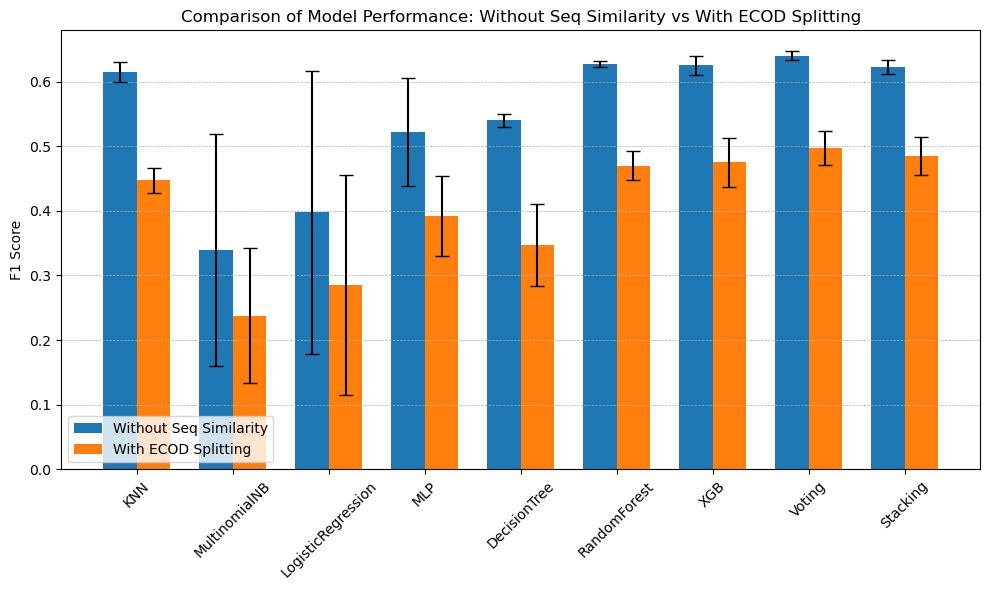

In [ ]:
# Macro f1 score comparison

# Results without sequence similarity filtering (raw)
results = {
    'KNN': [0.60, 0.60, 0.63, 0.63],
    'MultinomialNB': [0.10, 0.24, 0.47, 0.55],
    'LogisticRegression': [0.09, 0.29, 0.59, 0.62],
    'MLP': [0.40, 0.49, 0.60, 0.60],
    'DecisionTree': [0.53, 0.53, 0.55, 0.55],
    'RandomForest': [0.62, 0.63, 0.63, 0.63],
    'XGB': [0.61, 0.64, 0.64, 0.61],
    'Voting': [0.63, 0.64, 0.64, 0.65],
    'Stacking': [0.61, 0.62, 0.62, 0.64]
}

# Results with ECOD family-based splitting
ecod_results = {
    'KNN':  [0.43,0.44,0.44,0.48],
    'MultinomialNB': [0.10,0.18,0.30,0.37],
    'LogisticRegression': [0.10,0.13,0.44,0.47],
    'MLP': [0.30,0.38,0.42,0.47],
    'DecisionTree': [0.30,0.28,0.37,0.44],
    'RandomForest': [0.44,0.46,0.48,0.50],
    'XGB': [0.44, 0.44, 0.49, 0.53],
    'Voting': [0.46, 0.49, 0.51, 0.53],
    'Stacking': [0.44, 0.48, 0.50, 0.52]
}

# Calculate mean and standard deviation for each model
print("Model Performance Comparison:")
for model in results:
    arr = np.array(results[model])
    ecod_arr = np.array(ecod_results[model])
    print(f"{model}:")
    print(f"  Without Seq Similarity: Mean = {arr.mean():.2f}, Std = {arr.std():.2f}")
    print(f"  With ECOD Splitting:    Mean = {ecod_arr.mean():.2f}, Std = {ecod_arr.std():.2f}")
    print("")

# Prepare data for plotting
models = list(results.keys())
means_without = [np.mean(results[m]) for m in models]
std_without = [np.std(results[m]) for m in models]
means_ecod = [np.mean(ecod_results[m]) for m in models]
std_ecod = [np.std(ecod_results[m]) for m in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, means_without, width, yerr=std_without, capsize=5, label='Without Seq Similarity')
rects2 = ax.bar(x + width/2, means_ecod, width, yerr=std_ecod, capsize=5, label='With ECOD Splitting')

# Add labels and title
ax.set_ylabel('F1 Score')
ax.set_title('Comparison of Model Performance: Without Seq Similarity vs With ECOD Splitting')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

fig.tight_layout()
plt.show()


In [ ]:
# Create a summary table as a DataFrame
summary_df = pd.DataFrame({
    'Model': models,
    'Without Seq Similarity': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(means_without, std_without)],
    'With ECOD Splitting': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(means_ecod, std_ecod)]
})

print("Summary Table of Model Performance:")
print(summary_df)

Summary Table of Model Performance:
                Model Without Seq Similarity With ECOD Splitting
0                 KNN            0.61 ± 0.02         0.45 ± 0.02
1       MultinomialNB            0.34 ± 0.18         0.24 ± 0.10
2  LogisticRegression            0.40 ± 0.22         0.29 ± 0.17
3                 MLP            0.52 ± 0.08         0.39 ± 0.06
4        DecisionTree            0.54 ± 0.01         0.35 ± 0.06
5        RandomForest            0.63 ± 0.00         0.47 ± 0.02
6                 XGB            0.62 ± 0.02         0.48 ± 0.04
7              Voting            0.64 ± 0.01         0.50 ± 0.03
8            Stacking            0.62 ± 0.01         0.48 ± 0.03


In [ ]:
model_list = ['KNN', 'multinomialNB', 'Logistic Regression', 'MLP', 'Decision Tree', 'Random Forest', 'XGBoost', 'Voting Classifier', 'Stacking Classifier']
model_df2 = pd.DataFrame({'uni-gram accuracy': ecod_accuracy_list1, 'uni-gram f1-score': ecod_f1_list1, 'bi-gram accuracy': ecod_accuracy_list2, 'bi-gram f1-score': ecod_f1_list2, 'tri-gram accuracy': ecod_accuracy_list3, 'tri-gram f1-score': ecod_f1_list3, '4-gram accuracy': ecod_accuracy_list4, '4-gram f1-score': ecod_f1_list4}, index=model_list)

model_df2

,uni-gram accuracy,uni-gram f1-score,bi-gram accuracy,bi-gram f1-score,tri-gram accuracy,tri-gram f1-score,4-gram accuracy,4-gram f1-score
KNN,0.54,0.50,0.55,0.51,0.52,0.51,0.54,0.52
multinomialNB,0.18,0.17,0.19,0.19,0.39,0.38,0.43,0.42
Logistic Regression,0.18,0.17,0.19,0.17,0.50,0.48,0.56,0.54
MLP,0.41,0.39,0.46,0.44,0.50,0.49,0.58,0.54
Decision Tree,0.45,0.43,0.42,0.40,0.47,0.45,0.52,0.50
Random Forest,0.55,0.52,0.52,0.50,0.52,0.50,0.58,0.55
XGBoost,0.54,0.51,0.56,0.54,0.56,0.55,0.59,0.56
Voting Classifier,0.57,0.53,0.58,0.55,0.60,0.56,0.63,0.60
Stacking Classifier,0.55,0.51,0.58,0.55,0.61,0.56,0.62,0.59


Model Performance Comparison:
KNN:
  Without Seq Similarity: Mean = 0.73, Std = 0.01
  With ECOD Splitting:    Mean = 0.51, Std = 0.01

MultinomialNB:
  Without Seq Similarity: Mean = 0.39, Std = 0.19
  With ECOD Splitting:    Mean = 0.29, Std = 0.11

LogisticRegression:
  Without Seq Similarity: Mean = 0.45, Std = 0.26
  With ECOD Splitting:    Mean = 0.34, Std = 0.17

MLP:
  Without Seq Similarity: Mean = 0.66, Std = 0.07
  With ECOD Splitting:    Mean = 0.47, Std = 0.06

DecisionTree:
  Without Seq Similarity: Mean = 0.66, Std = 0.01
  With ECOD Splitting:    Mean = 0.45, Std = 0.04

RandomForest:
  Without Seq Similarity: Mean = 0.71, Std = 0.00
  With ECOD Splitting:    Mean = 0.52, Std = 0.02

XGB:
  Without Seq Similarity: Mean = 0.71, Std = 0.02
  With ECOD Splitting:    Mean = 0.54, Std = 0.02

Voting:
  Without Seq Similarity: Mean = 0.74, Std = 0.01
  With ECOD Splitting:    Mean = 0.56, Std = 0.03

Stacking:
  Without Seq Similarity: Mean = 0.74, Std = 0.00
  With ECOD Spli

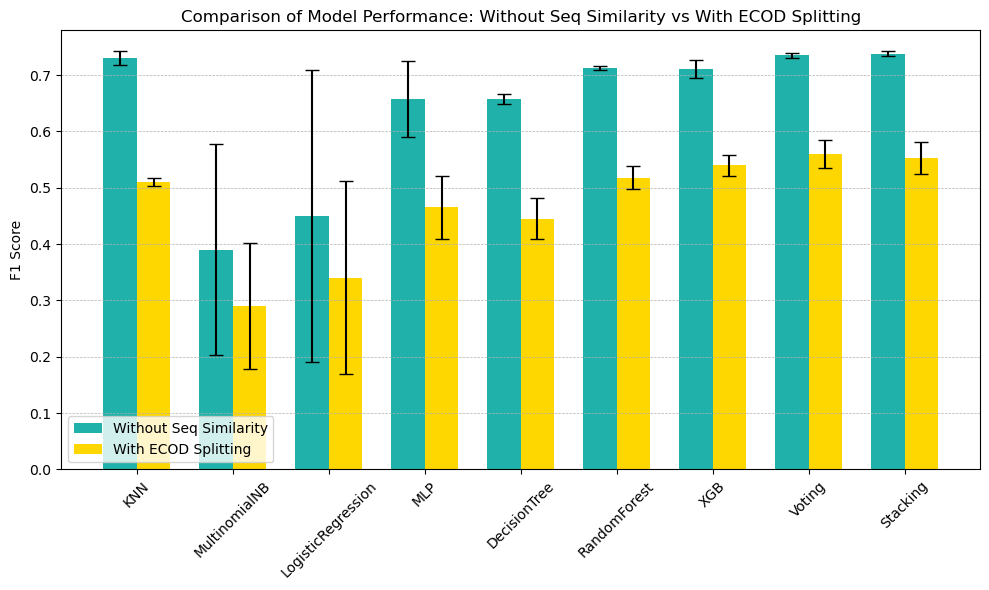

In [ ]:
# Weighted f1 score comparison
results = {
    'KNN': [0.71, 0.73, 0.74, 0.74],
    'MultinomialNB': [0.17, 0.26, 0.48, 0.65],
    'LogisticRegression': [0.09, 0.32, 0.67, 0.72],
    'MLP': [0.55, 0.65, 0.71, 0.72],
    'DecisionTree': [0.65, 0.65, 0.66, 0.67],
    'RandomForest': [0.71, 0.71, 0.71, 0.72],
    'XGB': [0.70, 0.73, 0.72, 0.69],
    'Voting': [0.73, 0.74, 0.73, 0.74],
    'Stacking': [0.73, 0.74, 0.74, 0.74]
}

# Results with ECOD family-based splitting
ecod_results = {
    'KNN': [0.50, 0.51, 0.51, 0.52],
    'MultinomialNB': [0.17, 0.19, 0.38, 0.42],
    'LogisticRegression': [0.17, 0.17, 0.48, 0.54],
    'MLP': [0.39, 0.44, 0.49, 0.54],
    'DecisionTree': [0.43, 0.40, 0.45, 0.50],
    'RandomForest': [0.52, 0.50, 0.50, 0.55],
    'XGB': [0.51, 0.54, 0.55, 0.56],
    'Voting': [0.53, 0.55, 0.56, 0.60],
    'Stacking': [0.51, 0.55, 0.56, 0.59]
}

# Calculate mean and standard deviation for each model
print("Model Performance Comparison:")
for model in results:
    arr = np.array(results[model])
    ecod_arr = np.array(ecod_results[model])
    print(f"{model}:")
    print(f"  Without Seq Similarity: Mean = {arr.mean():.2f}, Std = {arr.std():.2f}")
    print(f"  With ECOD Splitting:    Mean = {ecod_arr.mean():.2f}, Std = {ecod_arr.std():.2f}")
    print("")

# Prepare data for plotting
models = list(results.keys())
means_without = [np.mean(results[m]) for m in models]
std_without = [np.std(results[m]) for m in models]
means_ecod = [np.mean(ecod_results[m]) for m in models]
std_ecod = [np.std(ecod_results[m]) for m in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, means_without, width, yerr=std_without, capsize=5, label='Without Seq Similarity', color='lightseagreen')
rects2 = ax.bar(x + width/2, means_ecod, width, yerr=std_ecod, capsize=5, label='With ECOD Splitting', color='gold')

# Add labels and title
ax.set_ylabel('F1 Score')
ax.set_title('Comparison of Model Performance: Without Seq Similarity vs With ECOD Splitting')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

fig.tight_layout()

plt.savefig("figure1.tiff", format="tiff", dpi=300, bbox_inches='tight', transparent=False)

plt.show()

In [ ]:
# Create a summary table as a DataFrame
summary_df = pd.DataFrame({
    'Model': models,
    'Without Seq Similarity': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(means_without, std_without)],
    'With ECOD Splitting': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(means_ecod, std_ecod)]
})

print("Summary Table of Model Performance:")
print(summary_df)

Summary Table of Model Performance:
                Model Without Seq Similarity With ECOD Splitting
0                 KNN            0.73 ± 0.01         0.51 ± 0.01
1       MultinomialNB            0.39 ± 0.19         0.29 ± 0.11
2  LogisticRegression            0.45 ± 0.26         0.34 ± 0.17
3                 MLP            0.66 ± 0.07         0.47 ± 0.06
4        DecisionTree            0.66 ± 0.01         0.45 ± 0.04
5        RandomForest            0.71 ± 0.00         0.52 ± 0.02
6                 XGB            0.71 ± 0.02         0.54 ± 0.02
7              Voting            0.74 ± 0.01         0.56 ± 0.03
8            Stacking            0.74 ± 0.00         0.55 ± 0.03


Model Performance Comparison:
KNN:
  Without Seq Similarity: Mean = 0.71, Std = 0.02
  With ECOD Splitting:    Mean = 0.54, Std = 0.01

MultinomialNB:
  Without Seq Similarity: Mean = 0.38, Std = 0.18
  With ECOD Splitting:    Mean = 0.30, Std = 0.11

LogisticRegression:
  Without Seq Similarity: Mean = 0.45, Std = 0.25
  With ECOD Splitting:    Mean = 0.36, Std = 0.17

MLP:
  Without Seq Similarity: Mean = 0.67, Std = 0.06
  With ECOD Splitting:    Mean = 0.49, Std = 0.06

DecisionTree:
  Without Seq Similarity: Mean = 0.66, Std = 0.01
  With ECOD Splitting:    Mean = 0.46, Std = 0.04

RandomForest:
  Without Seq Similarity: Mean = 0.71, Std = 0.00
  With ECOD Splitting:    Mean = 0.54, Std = 0.02

XGB:
  Without Seq Similarity: Mean = 0.71, Std = 0.02
  With ECOD Splitting:    Mean = 0.56, Std = 0.02

Voting:
  Without Seq Similarity: Mean = 0.74, Std = 0.01
  With ECOD Splitting:    Mean = 0.59, Std = 0.02

Stacking:
  Without Seq Similarity: Mean = 0.74, Std = 0.01
  With ECOD Spli

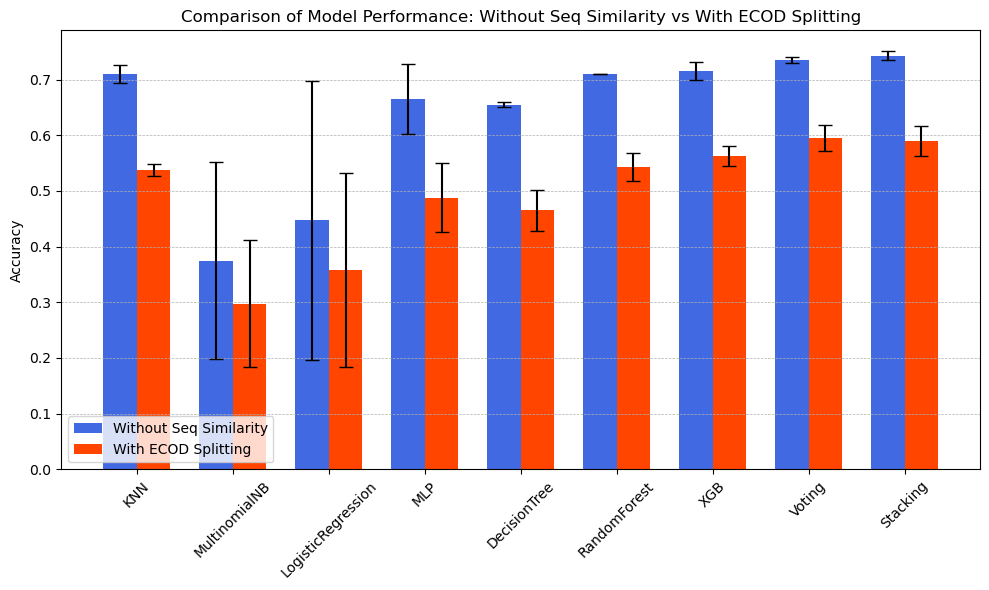

In [ ]:
# Accuracy
accuracy_list1 = [0.72, 0.17, 0.10, 0.57, 0.65, 0.71, 0.71, 0.73, 0.73]
accuracy_list2 = [0.73, 0.25, 0.32, 0.65, 0.65, 0.71, 0.73, 0.74, 0.75]
accuracy_list3 = [0.70, 0.46, 0.66, 0.71, 0.66, 0.71, 0.73, 0.73, 0.74]
accuracy_list4 = [0.69, 0.62, 0.71, 0.73, 0.66, 0.71, 0.69, 0.74, 0.75]

ecod_accuracy_list1 = [0.54, 0.18, 0.18, 0.41, 0.45, 0.55, 0.54, 0.57, 0.55]
ecod_accuracy_list2 = [0.55, 0.19, 0.19, 0.46, 0.42, 0.52, 0.56, 0.58, 0.58]
ecod_accuracy_list3 = [0.52, 0.39, 0.5, 0.5, 0.47, 0.52, 0.56, 0.6, 0.61]
ecod_accuracy_list4 = [0.54, 0.43, 0.56, 0.58, 0.52, 0.58, 0.59, 0.63, 0.62]


results = {
    'KNN': [0.72, 0.73, 0.70, 0.69],
    'MultinomialNB': [0.17, 0.25, 0.46, 0.62],
    'LogisticRegression': [0.10, 0.32, 0.66, 0.71],
    'MLP': [0.57, 0.65, 0.71, 0.73],
    'DecisionTree': [0.65, 0.65, 0.66, 0.66],
    'RandomForest': [0.71, 0.71, 0.71, 0.71],
    'XGB': [0.71, 0.73, 0.73, 0.69],
    'Voting': [0.73, 0.74, 0.73, 0.74],
    'Stacking': [0.73, 0.75, 0.74, 0.75]
}

# Results with ECOD family-based splitting
ecod_results = {
    'KNN': [0.54, 0.55, 0.52, 0.54],
    'MultinomialNB': [0.18, 0.19, 0.39, 0.43],
    'LogisticRegression': [0.18, 0.19, 0.50, 0.56],
    'MLP': [0.41, 0.46, 0.50, 0.58],
    'DecisionTree': [0.45, 0.42, 0.47, 0.52],
    'RandomForest': [0.55, 0.52, 0.52, 0.58],
    'XGB': [0.54, 0.56, 0.56, 0.59],
    'Voting': [0.57, 0.58, 0.60, 0.63],
    'Stacking': [0.55, 0.58, 0.61, 0.62]
}

# Calculate mean and standard deviation for each model
print("Model Performance Comparison:")
for model in results:
    arr = np.array(results[model])
    ecod_arr = np.array(ecod_results[model])
    print(f"{model}:")
    print(f"  Without Seq Similarity: Mean = {arr.mean():.2f}, Std = {arr.std():.2f}")
    print(f"  With ECOD Splitting:    Mean = {ecod_arr.mean():.2f}, Std = {ecod_arr.std():.2f}")
    print("")

# Prepare data for plotting
models = list(results.keys())
means_without = [np.mean(results[m]) for m in models]
std_without = [np.std(results[m]) for m in models]
means_ecod = [np.mean(ecod_results[m]) for m in models]
std_ecod = [np.std(ecod_results[m]) for m in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, means_without, width, yerr=std_without, capsize=5, label='Without Seq Similarity', color='royalblue')
rects2 = ax.bar(x + width/2, means_ecod, width, yerr=std_ecod, capsize=5, label='With ECOD Splitting', color='orangered')

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Performance: Without Seq Similarity vs With ECOD Splitting')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='lower left')
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

fig.tight_layout()

plt.savefig("figure2.tiff", format="tiff", dpi=300, bbox_inches='tight', transparent=False)
plt.show()

In [ ]:
# Create a summary table as a DataFrame
summary_df = pd.DataFrame({
    'Model': models,
    'Without Seq Similarity': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(means_without, std_without)],
    'With ECOD Splitting': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(means_ecod, std_ecod)]
})

print("Summary Table of Model Performance (Accuracy):")
print(summary_df)

Summary Table of Model Performance (Accuracy):
                Model Without Seq Similarity With ECOD Splitting
0                 KNN            0.71 ± 0.02         0.54 ± 0.01
1       MultinomialNB            0.38 ± 0.18         0.30 ± 0.11
2  LogisticRegression            0.45 ± 0.25         0.36 ± 0.17
3                 MLP            0.67 ± 0.06         0.49 ± 0.06
4        DecisionTree            0.66 ± 0.01         0.46 ± 0.04
5        RandomForest            0.71 ± 0.00         0.54 ± 0.02
6                 XGB            0.71 ± 0.02         0.56 ± 0.02
7              Voting            0.74 ± 0.01         0.59 ± 0.02
8            Stacking            0.74 ± 0.01         0.59 ± 0.03
